# **PROJET SEATTLE ENERGY BENCHMARKING**
## **Notebook 02 : Analyse univariée**

---

### Identité du document
* **Statut :** Phase finale (exploration univariée)
* **Date de création :** 01 Janvier 2026
* **Dernière mise à jour :** 01 Janvier 2026
* **Dépendances notebooks** : notebook_0 et notebook_1

### Description
Ce notebook constitue une **analyse univariée** des données de consommation énergétique et des émissions de CO₂ de la ville de Seattle.  
L'objectif est de **comprendre la distribution de chaque variable** dataset pour la construction d’un futur modèle de Machine Learning.

> **Philosophie :** "Connaître ses données avant de construire un modèle est la clé pour éviter les biais et les erreurs de prédiction."

### Objectifs principaux
1. **Explorer** les variables numériques et catégorielles individuellement.
2. **Analyser** les distributions statistiques (histogrammes, boxplots, stats descriptives).
3. **Préparer** une synthèse des transformations à prévoir pour le ML (normalisation, encodage).

### Dépendances critiques
* `pandas`, `numpy` : Manipulation et analyse de données.
* `matplotlib`, `seaborn` : Visualisations graphiques.

### LIVRABLES
1. **Tableau des statistiques descriptives** : moyenne, médiane, écart-type, min/max.
2. **Graphiques de distribution** : histogrammes et boxplots pour chaque variable.

# 📚 Table des matières

- [Section 0 : Importation et chargement](#section-0--importation-et-chargement)
- [Section 1 : Vue globale du dataset](#section-1--vue-globale-du-dataset)
- [Section 2 : Analyse de la variable cible – `TotalGHGEmissions`](#section-2--analyse-de-la-variable-cible--totalghgemissions)

- [Section 3 : Variables de consommation énergétique](#section-3--variables-de-consommation-énergétique)
- [Section 4 : Caractéristiques physiques des bâtiments](#section-4--caractéristiques-physiques-des-bâtiments)
- [Section 5 : Dimension temporelle – `YearBuilt`](#section-5--dimension-temporelle--yearbuilt)
- [Section 6 : Performance énergétique – `ENERGYSTARScore`](#section-6--performance-énergétique--energystarscore)

- [Section 7 : Analyse des variables qualitatives](#section-7--analyse-des-variables-qualitatives)


> **Note :** Les liens de la table des matières peuvent ne pas fonctionner selon votre éditeur. Utilisez plutôt l’outline ou la navigation intégrée (VSCode, JupyterLab, etc.) pour naviguer dans les sections.

# Section 0 : Importation et chargement

In [ ]:
import sys
import logging
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, skew, kurtosis
import warnings
import math
import pylab as py
import statsmodels.api as sm

# Configuration des chemins d'accès
PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

from data.load_data import load_data_raw
from data.clean_data import run_cleaning_pipeline
from utils.config_loader import load_config

# pour voir toutes les colonnes
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 100)

In [139]:
# Importation des données
cfg = load_config()
df_raw = load_data_raw(cfg)
df_cleaned = run_cleaning_pipeline(df_raw, cfg)
df_raw = df_cleaned

   [Audit] section_0 : -1752 lignes exportées vers section_0_removed.csv
   [Audit] section_1 : -119 lignes exportées vers section_1_removed.csv
   [Audit] section_2 : -47 lignes exportées vers section_2_removed.csv
   [Audit] section_3 : -63 lignes exportées vers section_3_removed.csv


# Section 1 : Vue globale du dataset

In [180]:
# Aperçu des premières lignes
print("="*80)
print("CINQ PREMIERES LIGNES DU DATASET")
print("="*80)
df_raw.head(5)

CINQ PREMIERES LIGNES DU DATASET


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,IsMixedUse,Has_EnergyStarScore,IsZeroFloorReported,IsAggregatedCampus,BuildingAge,AgeGroup
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.00,0659000030,7,Downtown,47.61,-122.34,1927,1.00,12,88434,0,88434,Hotel,Hotel,88434.00,60.00,81.70,84.32,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,False,Compliant,249.98,2.83,0,1,0,0,89,Old
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.00,0659000220,7,Downtown,47.61,-122.33,1996,1.00,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.00,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,False,Compliant,295.86,2.86,1,1,0,0,20,New
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.00,0659000640,7,Downtown,47.61,-122.34,1926,1.00,10,61320,0,61320,Hotel,Hotel,61320.00,56.00,110.80,113.29,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,False,Compliant,286.43,4.67,0,1,0,0,90,Old
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.00,0659000970,7,Downtown,47.61,-122.34,1980,1.00,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.00,75.00,114.80,129.04,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,False,Compliant,505.01,2.88,1,1,0,0,36,Mid-Aged
5,9,2016,Nonresidential COS,Other,West Precinct,810 Virginia St,Seattle,WA,98101.00,0660000560,7,Downtown,47.62,-122.34,1999,1.00,2,97288,37198,60090,Police Station,Police Station,88830.00,72.00,136.10,209.38,316.30,320.50,12086616.00,12581712.00,0.00,2160443.75,7371434.00,47151.82,4715182.00,False,Compliant,301.81,3.10,0,0,0,0,17,New


In [181]:
#  Aperçu général
print("="*80)
print("INFORMATIONS GENERALES DU DATASET")
print("="*80)

df_raw.columns

INFORMATIONS GENERALES DU DATASET


Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'ComplianceStatus', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'IsMixedUse', 'Has_EnergyStarScore',
       'IsZeroFloorReported', 'IsAggregatedCampus', 'BuildingAge', 'AgeGroup'],
      dtype='object')

In [182]:
#  Aperçu général
print("="*80)
print("INFORMATIONS GENERALES DU DATASET")
print("="*80)

df_raw.shape

INFORMATIONS GENERALES DU DATASET


(1395, 45)

In [183]:
#  Aperçu général
print("="*80)
print("INFORMATIONS GENERALES DU DATASET")
print("="*80)

df_raw.info()

INFORMATIONS GENERALES DU DATASET
<class 'pandas.core.frame.DataFrame'>
Index: 1395 entries, 0 to 3375
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   OSEBuildingID                  1395 non-null   int64   
 1   DataYear                       1395 non-null   int64   
 2   BuildingType                   1395 non-null   object  
 3   PrimaryPropertyType            1395 non-null   object  
 4   PropertyName                   1395 non-null   object  
 5   Address                        1395 non-null   object  
 6   City                           1395 non-null   object  
 7   State                          1395 non-null   object  
 8   ZipCode                        1395 non-null   float64 
 9   TaxParcelIdentificationNumber  1395 non-null   object  
 10  CouncilDistrictCode            1395 non-null   int64   
 11  Neighborhood                   1395 non-null   object  
 12  Latit

In [184]:
#  Types de variables
print("\n" + "="*80)
print("TYPES DES VARIABLES DU DATASET BRUT")
print("="*80)
print(df_raw.dtypes.value_counts())


TYPES DES VARIABLES DU DATASET BRUT
float64     19
object      11
int64        8
int32        5
bool         1
category     1
Name: count, dtype: int64


In [189]:
print("\n" + "="*80)
print("TYPES DES VARIABLES DU DATASET BRUT DÉTAILLÉS")
print("="*80)

print("\nTypes des variables :")
print(df_raw.dtypes)


TYPES DES VARIABLES DU DATASET BRUT DÉTAILLÉS

Types des variables :
OSEBuildingID                       int64
DataYear                            int64
BuildingType                       object
PrimaryPropertyType                object
PropertyName                       object
Address                            object
City                               object
State                              object
ZipCode                           float64
TaxParcelIdentificationNumber      object
CouncilDistrictCode                 int64
Neighborhood                       object
Latitude                          float64
Longitude                         float64
YearBuilt                           int64
NumberofBuildings                 float64
NumberofFloors                      int32
PropertyGFATotal                    int64
PropertyGFAParking                  int64
PropertyGFABuilding(s)              int64
ListOfAllPropertyUseTypes          object
LargestPropertyUseType             object
Larges

# Section 2 : Analyse de la variable cible : `TotalGHGEmissions`

**Objectif :**  
Produire une **vue complète et hiérarchisée** de la variable cible, en examinant sa **distribution, ses statistiques descriptives et ses valeurs extrêmes**, afin de préparer la construction du modèle de Machine Learning.

**Questions clés :**  
1. Quelle est la **distribution** de `TotalGHGEmissions` (histogramme, densité, asymétrie) ?  
2. Quelles sont les **valeurs centrales** : moyenne, médiane, quartiles ?    
3. Faut-il **transformer** la variable (log, normalisation) pour réduire la skewness ou l’influence des outliers ?  
4. Existe-t-il des **patterns particuliers** dans `TotalGHGEmissions` selon des variables catégorielles (ex: BuildingType, PrimaryUse) ?  

La variable cible du modèle est le niveau total annuel d’émissions de gaz à effet de serre, mesuré en tonnes de CO₂ équivalent **TotalGHGEmissions**. Cette variable synthétise l’impact environnemental direct et indirect des consommations énergétiques du bâtiment, en tenant compte des facteurs d’émission associés aux différentes sources d’énergie utilisées. La variable **GHGEmissionsIntensity** bien que portant sur les émissions de CO₂ introduit un niveau de complexité supplémentaire car elle combine les émissions totales avec d’autres variable (surface, consommation d’énergie). Cela peut créer une corrélation forte avec les variables explicatives, rendant le modèle plus instable. Dans ce contexte, le choix de cette variable comme variable ciblée serait mal adapté.

### Statistiques descriptives

In [212]:
print("\n" + "="*60)
print("Analyse univariée de la variable cible : TotalGHGEmissions")
print("="*60)
    
print('\nTotalGHGEmissions')
print('----'*10)
print("moy:", df_raw['TotalGHGEmissions'].mean())
print("med:", df_raw['TotalGHGEmissions'].median())
print("max:", df_raw['TotalGHGEmissions'].max())
print("min:", df_raw['TotalGHGEmissions'].min())
print("std:", df_raw['TotalGHGEmissions'].std(ddof=0))
print("skw:", df_raw['TotalGHGEmissions'].skew())
print("kur:", df_raw['TotalGHGEmissions'].kurtosis())


Analyse univariée de la variable cible : TotalGHGEmissions

TotalGHGEmissions
----------------------------------------
moy: 138.759770609319
med: 46.01
max: 12307.16
min: 0.4
std: 540.2678228191189
skw: 16.77274941638983
kur: 329.0333410906843


La variable **TotalGHGEmissions** présente des caractéristiques statistiques très marquées, révélant une distribution fortement atypique. La moyenne (138.76) est près de trois fois supérieure à la médiane (46.01), ce qui indique que la distribution est tirée vers le haut par un nombre restreint de bâtiments extrêmement émetteurs, rendant la médiane plus représentative de la valeur typique. L’écart-type très élevé (540.27), comparé à la moyenne, ainsi que l’amplitude importante entre le minimum (0.4) et le maximum (12 307.16), traduisent une variabilité extrême des émissions. La skewness fortement positive (16.77) met en évidence une asymétrie extrême à droite, tandis que la kurtosis exceptionnellement élevée (329.03) révèle une distribution très leptokurtique, caractérisée par des queues lourdes et une forte présence d’outliers. Ces résultats confirment que la distribution est non normale, fortement asymétrique et dominée par des valeurs extrêmes, ce qui est cohérent avec la réalité métier où quelques grandes infrastructures concentrent l’essentiel des émissions. En conséquence, l’utilisation directe de cette variable dans un modèle linéaire serait inadaptée et une transformation logarithmique de type `log(TotalGHGEmissions + 1)` est fortement recommandée afin de réduire l’influence des valeurs extrêmes, stabiliser la variance et améliorer la robustesse des modèles.

In [213]:
print("\n" + "="*20)
print("Quartiles")
print("="*20)

print('\nTotalGHGEmissions')
print('----'*10)

print(f"Q1 (25%): {df_raw['TotalGHGEmissions'].quantile(0.25):.2f} tonnes CO2")
print(f"Q2 (50%): {df_raw['TotalGHGEmissions'].quantile(0.50):.2f} tonnes CO2")
print(f"Q3 (75%): {df_raw['TotalGHGEmissions'].quantile(0.75):.2f} tonnes CO2")
print(f"IQR (Interquartile): {df_raw['TotalGHGEmissions'].quantile(0.75) - df_raw['TotalGHGEmissions'].quantile(0.25):.2f} tonnes CO2")


Quartiles

TotalGHGEmissions
----------------------------------------
Q1 (25%): 19.54 tonnes CO2
Q2 (50%): 46.01 tonnes CO2
Q3 (75%): 120.88 tonnes CO2
IQR (Interquartile): 101.35 tonnes CO2


L’analyse des quartiles de **TotalGHGEmissions** confirme la forte hétérogénéité de la distribution. Le premier quartile (Q1 = 19.54 tonnes de CO₂) indique que 25 % des bâtiments émettent moins de ce niveau, tandis que la médiane (Q2 = 46.01 tonnes de CO₂) montre qu’un bâtiment “typique” présente des émissions relativement modérées. En revanche, le troisième quartile (Q3 = 120.88 tonnes de CO₂) révèle qu’au-delà de ce seuil, les émissions augmentent rapidement pour une fraction limitée des bâtiments. L’intervalle interquartile (IQR = 101.35 tonnes de CO₂), particulièrement large, traduit une dispersion importante au cœur même de la distribution et suggère une forte variabilité entre bâtiments. Cette configuration renforce l’idée que les émissions sont très inégalement réparties et qu’une minorité d’observations contribue de manière disproportionnée au niveau global des émissions.

### Test de normalité et visualisation

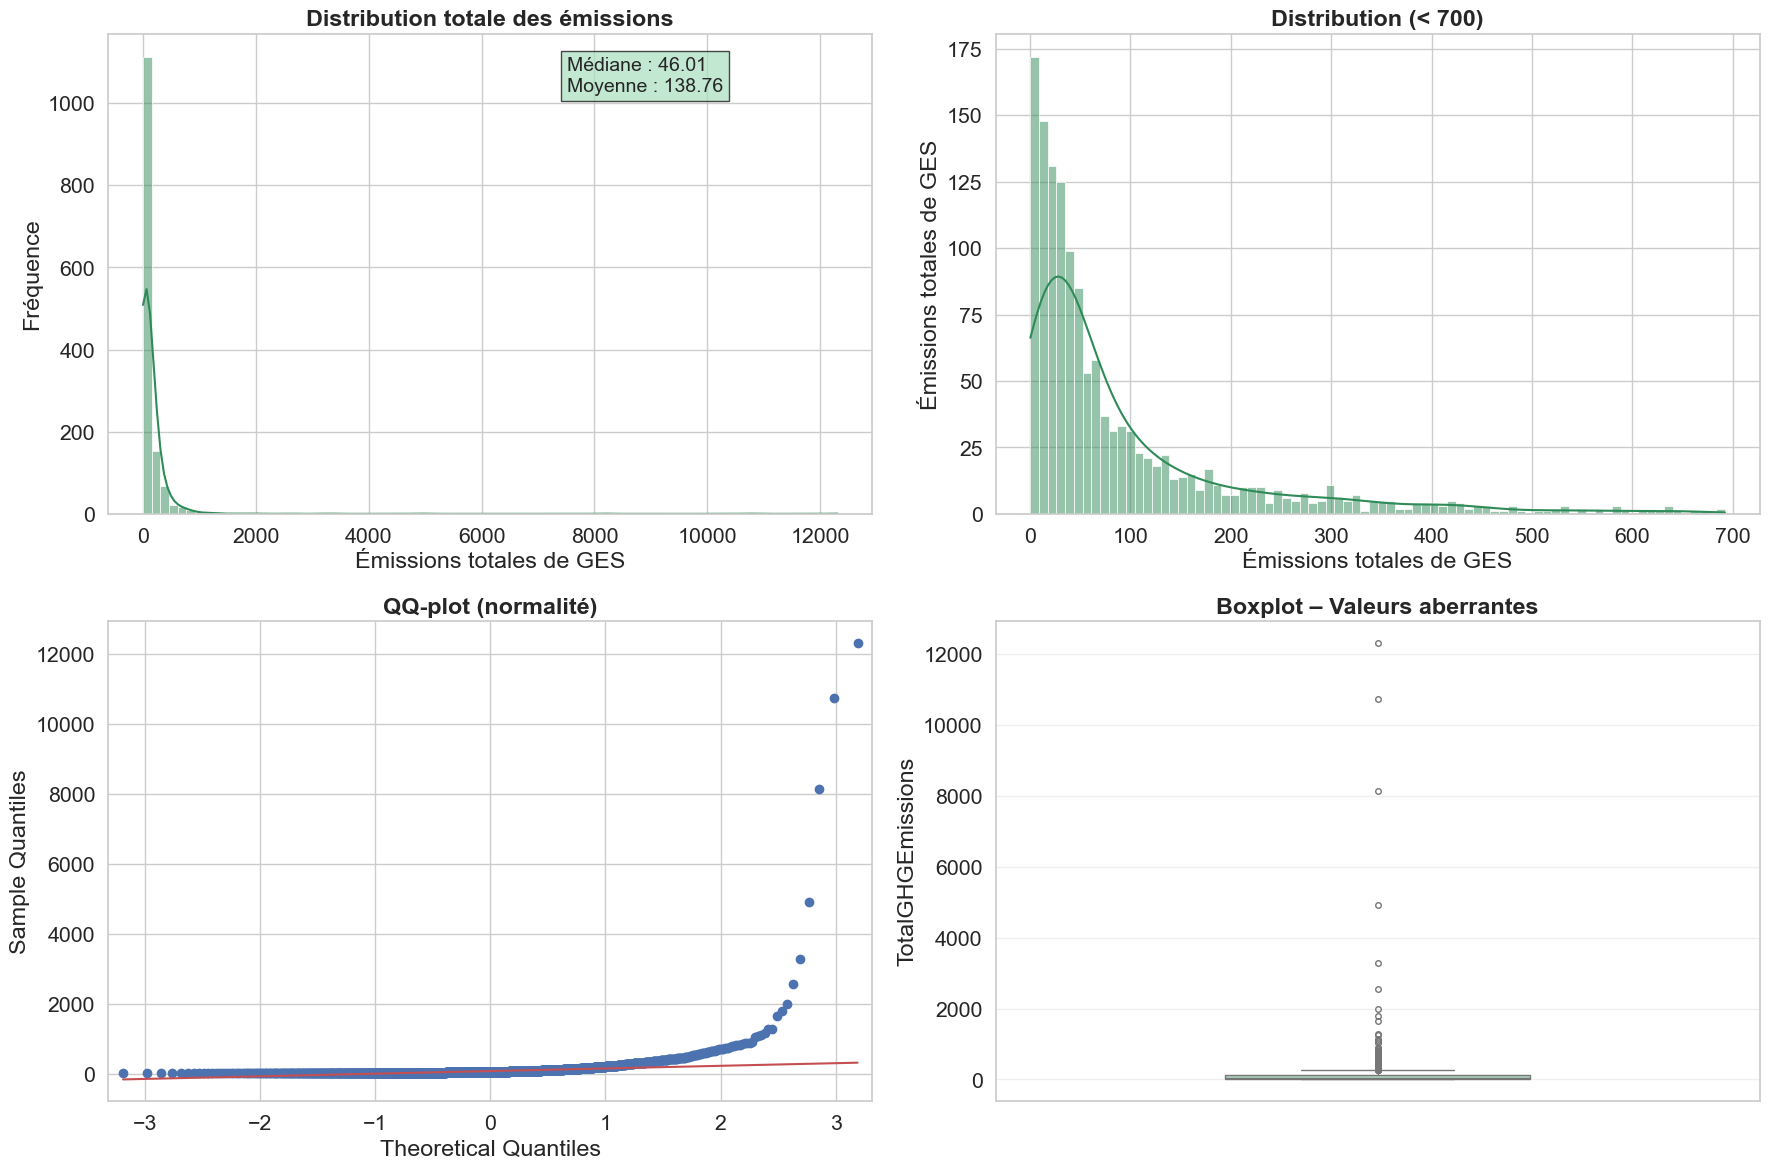

In [148]:
main_color = "#2E8B57"   # SeaGreen
box_color = "#A9DFBF"    # Light green

sns.set(
    rc={'figure.figsize': (18, 12)},
    font_scale=1.4,
    style="whitegrid"
)

fig, axes = plt.subplots(2, 2)


#  Histogramme global

sns.histplot(
    df_raw,
    x='TotalGHGEmissions',
    kde=True,
    bins=80,
    color=main_color,
    ax=axes[0, 0]
)

axes[0, 0].text(
    0.60, 0.88,
    f"Médiane : {df_raw['TotalGHGEmissions'].median():.2f}\n"
    f"Moyenne : {df_raw['TotalGHGEmissions'].mean():.2f}",
    transform=axes[0, 0].transAxes,
    fontsize=14,
    bbox=dict(facecolor=box_color, alpha=0.7, edgecolor='black')
)

axes[0, 0].set_title("Distribution totale des émissions", fontweight='bold')
axes[0, 0].set_xlabel("Émissions totales de GES")
axes[0, 0].set_ylabel("Fréquence")

#  Histogramme tronqué

sns.histplot(
    df_raw[df_raw['TotalGHGEmissions'] < 700],
    x='TotalGHGEmissions',
    kde=True,
    bins=80,
    color=main_color,
    ax=axes[0, 1]
)

axes[0, 1].set_title("Distribution (< 700)", fontweight='bold')
axes[0, 1].set_xlabel("Émissions totales de GES")
axes[0, 1].set_ylabel("Fréquence")

#  QQ-plot

sm.qqplot(
    df_raw['TotalGHGEmissions'],
    line='q',
    ax=axes[1, 0]
)

axes[1, 0].set_title("QQ-plot (normalité)", fontweight='bold')

# Boxplot

sns.boxplot(
    y=df_raw['TotalGHGEmissions'],
    ax=axes[1, 1],
    color=box_color,
    width=0.4,
    fliersize=4
)

axes[1, 1].set_title("Boxplot – Valeurs aberrantes", fontweight='bold')
axes[0, 1].set_ylabel("Émissions totales de GES")
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Les visualisations confirment le caractère atypique de la distribution de **TotalGHGEmissions**. L’histogramme global met en évidence une concentration massive des observations à de faibles niveaux d’émissions, tandis qu’une longue queue à droite s’étend jusqu’à des valeurs extrêmement élevées, traduisant la présence de quelques bâtiments très fortement émetteurs. L’histogramme tronqué (< 700) permet de mieux observer la structure principale de la distribution et révèle une décroissance rapide des fréquences à mesure que les émissions augmentent, caractéristique d’une distribution très asymétrique.

Le Q-Q plot montre un écart marqué par rapport à la droite de normalité, en particulier dans les quantiles supérieurs, ce qui confirme la non-normalité de la variable et l’existence de valeurs extrêmes influentes. Enfin, le boxplot met en évidence un nombre important d’outliers, largement au-dessus de l’intervalle interquartile, soulignant une dispersion extrême et une forte hétérogénéité entre bâtiments. Ces éléments graphiques convergent vers la conclusion que **TotalGHGEmissions** est dominée par des valeurs extrêmes et nécessite une transformation (logarithmique) avant toute modélisation.

In [149]:

from scipy.stats import normaltest, shapiro, kstest, anderson, jarque_bera

print(' \nTests sur la variable TotalGHGEmissions')
print('----'*10)

target = df_raw['TotalGHGEmissions'].dropna()
log_target = np.log1p(target)

alpha = 0.05


# Fonction d'interprétation

def interpret_test(p_value, alpha=0.05):
    return "Distribution compatible avec la normalité (H0 non rejetée)" \
        if p_value > alpha else "Distribution non normale (H0 rejetée)"


# D’Agostino-Pearson (normaltest)
print("\n" + "=" * 60)
stat, p = normaltest(target)
print("TotalGHGEmissions Agostino-Pearson")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)


# Shapiro

if len(target) < 5000:
    stat, p = shapiro(target)
    print("TotalGHGEmissions Shapiro")
    print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
    print(interpret_test(p))
else:
    print("Shapiro non exécuté : échantillon trop grand (>5000)")
print("=" * 60)


# Kolmogorov–Smirnov

# On compare avec la distribution normale standardisée
target_std = (target - target.mean()) / target.std()
stat, p = kstest(target_std, 'norm')
print("TotalGHGEmissions Kolmogorov–Smirnov")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)


# Jarque-Bera

stat, p = jarque_bera(target)
print("TotalGHGEmissions Jarque-Bera")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)

 
Tests sur la variable TotalGHGEmissions
----------------------------------------

TotalGHGEmissions Agostino-Pearson
Statistic = 2881.787, p-value = 0.000e+00
Distribution non normale (H0 rejetée)
TotalGHGEmissions Shapiro
Statistic = 0.164, p-value = 2.211e-61
Distribution non normale (H0 rejetée)
TotalGHGEmissions Kolmogorov–Smirnov
Statistic = 0.399, p-value = 7.266e-201
Distribution non normale (H0 rejetée)
TotalGHGEmissions Jarque-Bera
Statistic = 6312903.384, p-value = 0.000e+00
Distribution non normale (H0 rejetée)


Nous remarquons que la variable cible ne suit pas une loi normale. Nous allons effectuer quelques transformations (log, box-cox, etc.) afin d'avoir une distribution normale ou proche.

### Transformation logarithmique de la variable cible

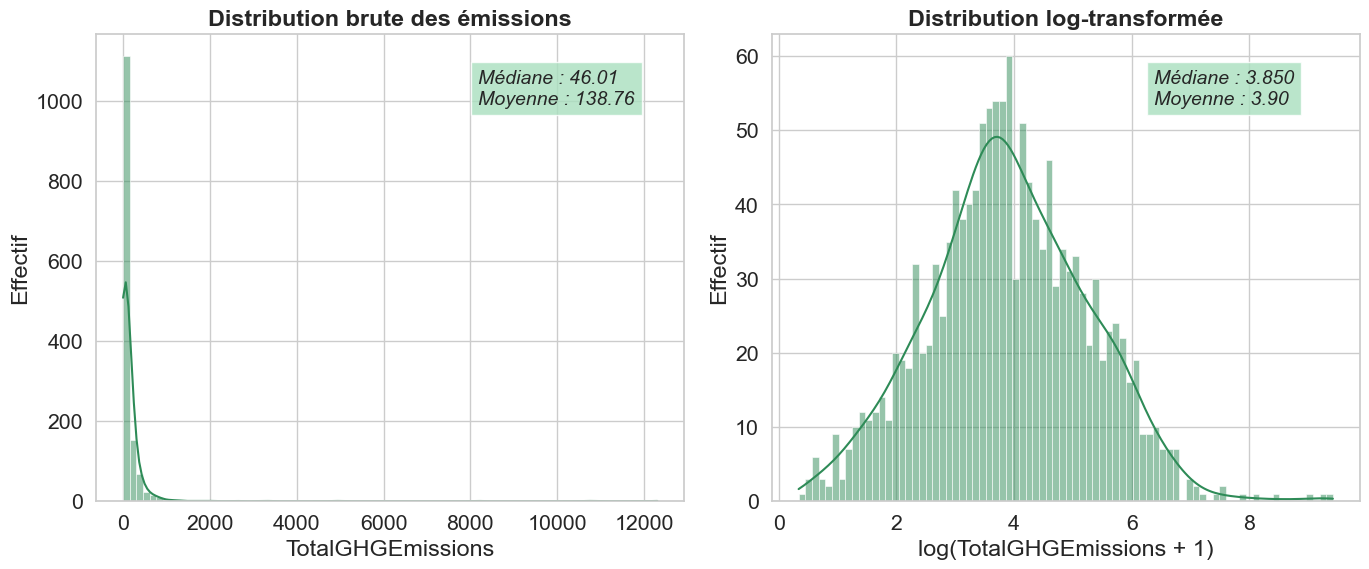

In [150]:
# Histogrammes comparatifs : variable brute vs log-transformée
main_color = "#2E8B57"   # SeaGreen
box_color  = "#A9DFBF"   # Light green


sns.set(
    style="whitegrid",
    rc={"figure.figsize": (14, 6)},
    font_scale=1.4
)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=False)


# 1. Histogramme variable brute

target = df_raw['TotalGHGEmissions'].dropna()

ax1 = sns.histplot(
    target,
    bins=80,
    kde=True,
    color=main_color,
    ax=axes[0]
)

ax1.text(
    0.65, 0.85,
    f"Médiane : {target.median():.2f}\n"
    f"Moyenne : {target.mean():.2f}",
    transform=ax1.transAxes,
    fontsize=14,
    style='italic',
    bbox=dict(facecolor=box_color, alpha=0.8, pad=5)
)

ax1.set_title("Distribution brute des émissions", fontweight="bold")
ax1.set_xlabel("TotalGHGEmissions")
ax1.set_ylabel("Effectif")


# Histogramme log-transformé

log_target = np.log1p(target)

ax2 = sns.histplot(
    log_target,
    bins=80,
    kde=True,
    color=main_color,
    ax=axes[1]
)

ax2.text(
    0.65, 0.85,
    f"Médiane : {log_target.median():.3f}\n"
    f"Moyenne : {log_target.mean():.2f}",
    transform=ax2.transAxes,
    fontsize=14,
    style='italic',
    bbox=dict(facecolor=box_color, alpha=0.8, pad=5)
)

ax2.set_title("Distribution log-transformée", fontweight="bold")
ax2.set_xlabel("log(TotalGHGEmissions + 1)")
ax2.set_ylabel("Effectif")


plt.tight_layout()
plt.show()


In [151]:
# Tests de normalité sur la variable log-transformée
log_target = np.log1p(df_raw['TotalGHGEmissions'].dropna())

alpha = 0.05

# Standardisation
log_target_std = (log_target - log_target.mean()) / log_target.std()

# D’Agostino–Pearson
print("\n" + "=" * 60)
stat, p = normaltest(log_target)
print("log(TotalGHGEmissions) Agostino-Pearson")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)

# Shapiro
if len(log_target) < 5000:
    stat, p = shapiro(log_target)
    print("log(TotalGHGEmissions) Shapiro")
    print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
    print(interpret_test(p))
else:
    print("Shapiro non exécuté : échantillon trop grand (>5000)")
print("=" * 60)

# Kolmogorov–Smirnov
stat, p = kstest(log_target_std, 'norm')
print("log(TotalGHGEmissions) Kolmogorov–Smirnov")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)

# Jarque–Bera
stat, p = jarque_bera(log_target)
print("log(TotalGHGEmissions) Jarque-Bera")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)


log(TotalGHGEmissions) Agostino-Pearson
Statistic = 5.175, p-value = 7.522e-02
Distribution compatible avec la normalité (H0 non rejetée)
log(TotalGHGEmissions) Shapiro
Statistic = 0.996, p-value = 1.465e-03
Distribution non normale (H0 rejetée)
log(TotalGHGEmissions) Kolmogorov–Smirnov
Statistic = 0.025, p-value = 3.629e-01
Distribution compatible avec la normalité (H0 non rejetée)
log(TotalGHGEmissions) Jarque-Bera
Statistic = 5.088, p-value = 7.854e-02
Distribution compatible avec la normalité (H0 non rejetée)


Les tests de normalité appliqués à la variable **log(TotalGHGEmissions)** montrent des résultats globalement en faveur d’une distribution proche de la normalité. Les tests de D’Agostino–Pearson, de Kolmogorov–Smirnov et de Jarque–Bera ne rejettent pas l’hypothèse nulle de normalité au seuil de 5 %, suggérant que la transformation logarithmique a significativement corrigé l’asymétrie et l’influence des valeurs extrêmes observées dans la variable brute. En revanche, le test de Shapiro–Wilk rejette encore la normalité, ce qui est cohérent avec sa forte sensibilité aux écarts mineurs dans des échantillons de grande taille. Dans l’ensemble, ces résultats indiquent que la transformation logarithmique améliore substantiellement le comportement distributionnel de la variable et la rend suffisamment compatible avec les hypothèses de nombreux modèles statistiques et de Machine Learning.

### Patterns

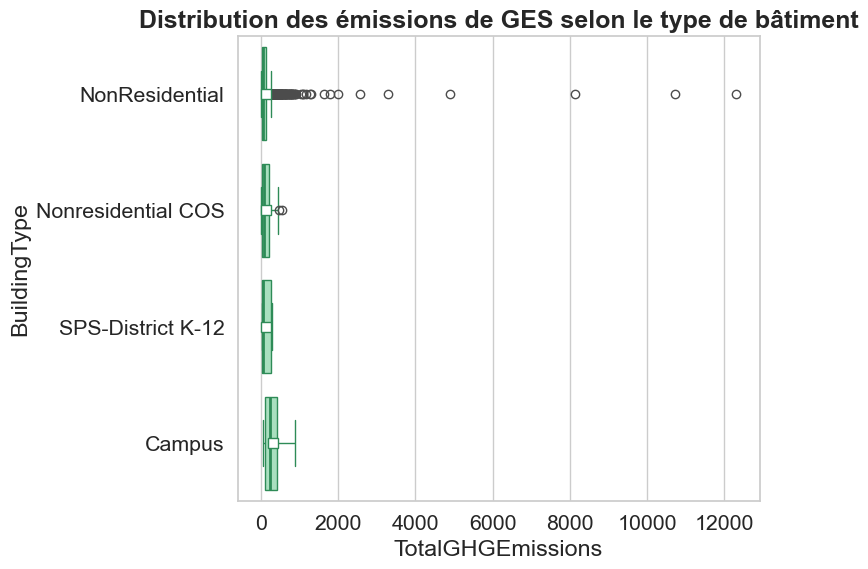

In [201]:
main_color = "#2E8B57"   # SeaGreen
box_color  = "#A9DFBF"   # Light green

plt.figure(figsize=(8, 6))

sns.boxplot(
    data=df_raw[df_raw['TotalGHGEmissions'].notna()],
    y='BuildingType',
    x='TotalGHGEmissions',
    showmeans=True,
    saturation=0.3,
    boxprops=dict(facecolor=box_color, edgecolor=main_color),
    whiskerprops=dict(color=main_color),
    capprops=dict(color=main_color),
    medianprops=dict(color=main_color, linewidth=2),
    meanprops={
        "marker": "s",
        "markerfacecolor": "white",
        "markeredgecolor": main_color,
        "markersize": 7
    }
)

plt.title(
    "Distribution des émissions de GES selon le type de bâtiment",
    fontsize=18,
    fontweight="bold"
)
plt.xlabel("TotalGHGEmissions")
plt.ylabel("BuildingType")

plt.tight_layout()
plt.show()

In [193]:
pattern_table = (
    df_raw[df_raw['TotalGHGEmissions'] < 2500]
    .groupby('BuildingType')['TotalGHGEmissions']
    .agg(['count', 'mean', 'median', 'std'])
    .sort_values('median', ascending=False)
)
pattern_table

,count,mean,median,std
BuildingType,,,,
Campus,17,316.09,218.79,256.83
Nonresidential COS,73,130.46,83.10,127.48
SPS-District K-12,9,131.70,49.55,115.97
NonResidential,1290,105.09,43.54,176.17


L’analyse des émissions de gaz à effet de serre selon le type de bâtiment met en évidence des différences nettes à la fois en termes de niveau et de dispersion, confirmant l’existence de patterns structurels. Les campus se distinguent par les niveaux d’émissions les plus élevés, avec une médiane de 218.79 et une moyenne de 316.09, ce qui s’explique par la présence de plusieurs bâtiments, des surfaces importantes et une activité énergétique soutenue. Les catégories Nonresidential COS et SPS-District K-12 présentent des niveaux intermédiaires, tandis que les bâtiments NonResidential, bien que très majoritaires dans l’échantillon, affichent une médiane plus faible (43.54), traduisant une forte hétérogénéité interne. Toutes les catégories présentent un écart-type élevé, indiquant une variabilité intra-groupe importante, et la différence marquée entre moyenne et médiane, en particulier pour les campus et les bâtiments non résidentiels, révèle une asymétrie à droite caractérisée par la présence de quelques établissements très fortement émetteurs. Ces résultats confirment que le type de bâtiment constitue un facteur structurant dans l’explication des émissions de GES, tout en soulignant la nécessité de le combiner à d’autres variables explicatives pour tenir compte de l’hétérogénéité observée.

## Section 3 : Variables de consommation énergétique

Cette section est consacrée à l’analyse univariée des **variables quantitatives liées à la consommation énergétique** des établissements. L’objectif est d’évaluer leur comportement statistique individuel afin d’identifier leur distribution, leur dispersion et les éventuelles anomalies susceptibles d’influencer la phase de modélisation.

### Objectifs principaux
1. **Explorer individuellement** les variables de consommation énergétique afin de comprendre leur ordre de grandeur et leur variabilité.
2. **Analyser les distributions statistiques** à l’aide de statistiques descriptives (moyenne, médiane, écart-type, minimum, maximum) et de visualisations adaptées (histogrammes, boxplots).
3. **Identifier les caractéristiques problématiques** telles que l’asymétrie marquée, la présence d’outliers ou une forte hétérogénéité entre observations.
4. **Préparer la phase de Machine Learning** en formulant des recommandations sur les transformations nécessaires (normalisation, standardisation ou transformation logarithmique).

### Dépendances critiques
Les bibliothèques suivantes sont utilisées pour cette analyse :
- **pandas, numpy** : manipulation des données et calcul des statistiques descriptives  
- **matplotlib, seaborn** : visualisation des distributions et détection graphique des valeurs aberrantes  

### Livrables
1. **Tableau des statistiques descriptives** pour chaque variable de consommation énergétique  
   (moyenne, médiane, écart-type, minimum, maximum).
2. **Graphiques de distribution univariés**  
   - histogrammes pour analyser la forme des distributions,  
   - boxplots pour identifier la dispersion et les valeurs aberrantes.


=== SteamUse(kBtu) ===
count: 1395.00
mean: 361058.41
median: 0.00
min: 0.00
max: 134943456.00
std: 5019206.08
skewness: 24.43
kurtosis: 623.74


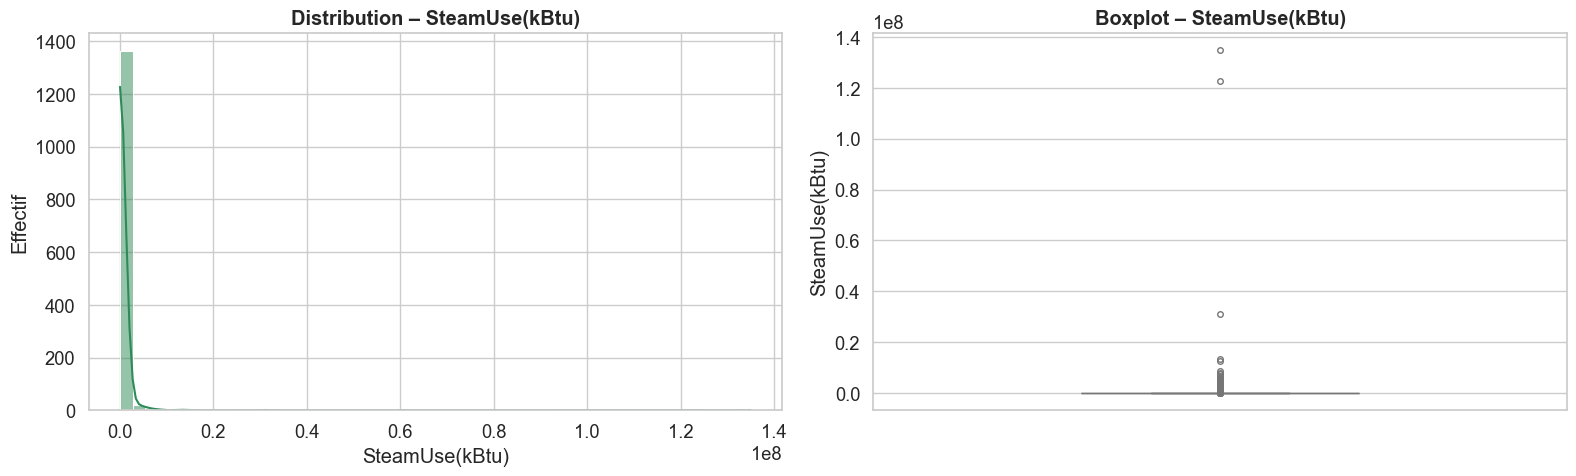


=== Electricity(kWh) ===
count: 1395.00
mean: 1414813.91
median: 455209.59
min: 0.00
max: 49438336.00
std: 3107765.77
skewness: 7.09
kurtosis: 76.10


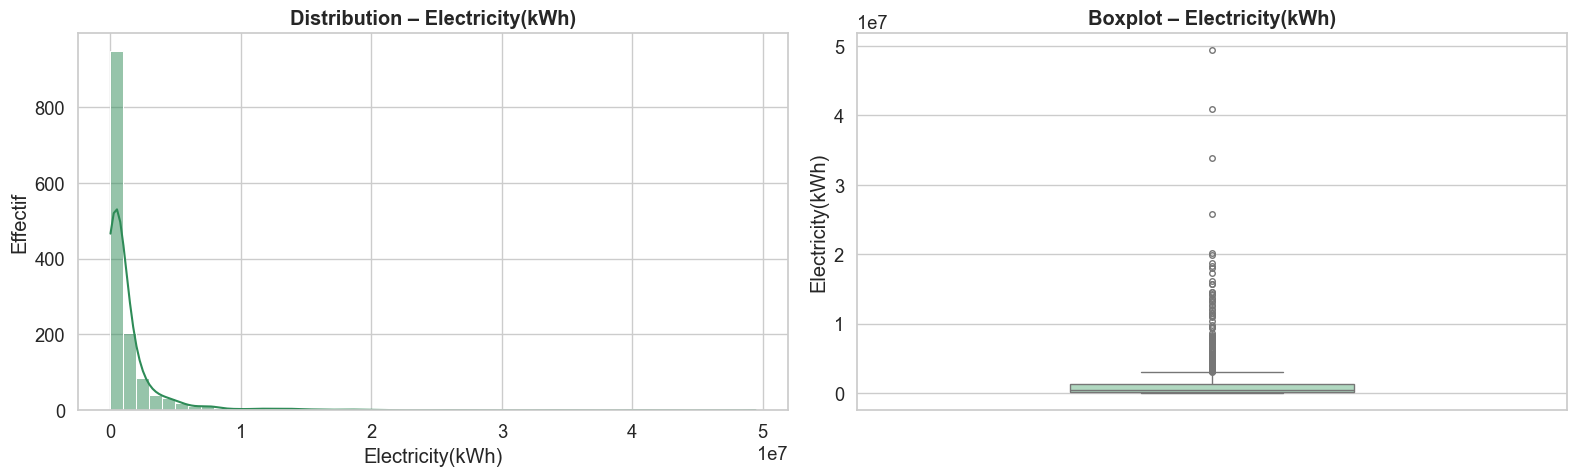


=== Electricity(kBtu) ===
count: 1395.00
mean: 4827345.06
median: 1553175.00
min: 0.00
max: 168683602.00
std: 10603696.79
skewness: 7.09
kurtosis: 76.10


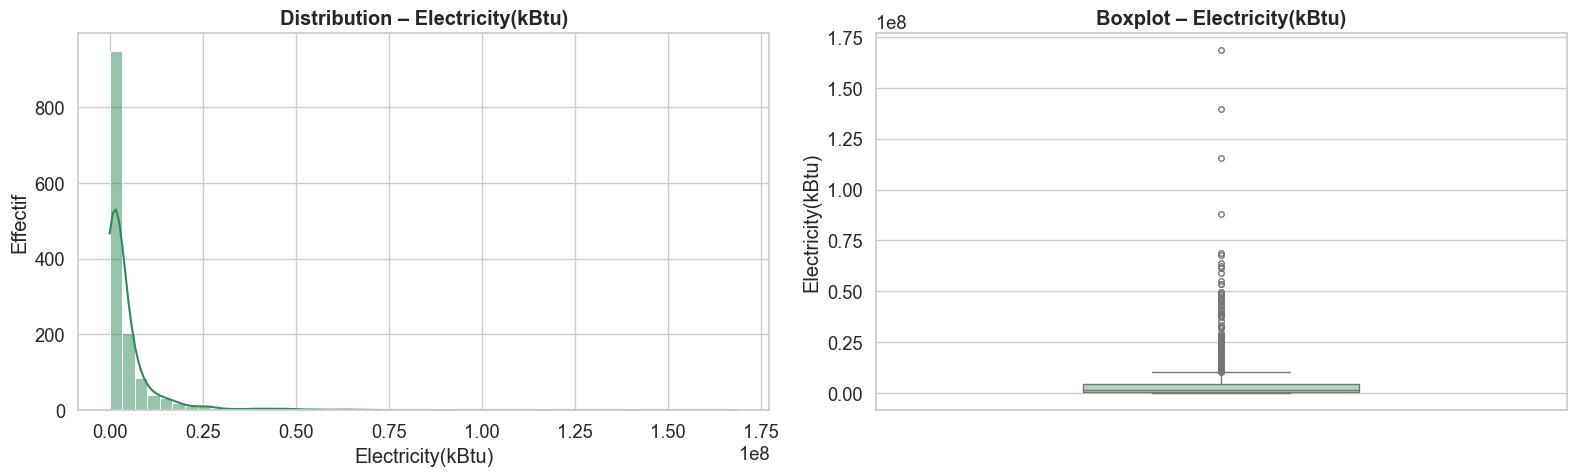


=== NaturalGas(therms) ===
count: 1395.00
mean: 14542.84
median: 4248.65
min: 0.00
max: 1381912.38
std: 52015.62
skewness: 17.44
kurtosis: 399.66


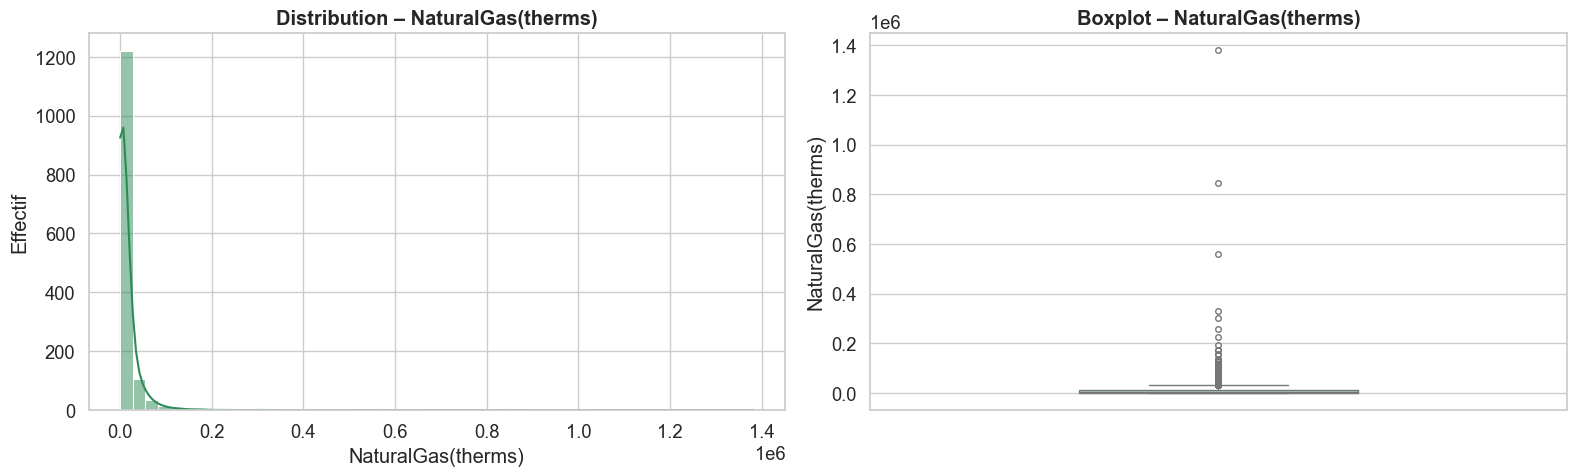


=== NaturalGas(kBtu) ===
count: 1395.00
mean: 1454283.98
median: 424865.00
min: 0.00
max: 138191238.00
std: 5201561.85
skewness: 17.44
kurtosis: 399.66


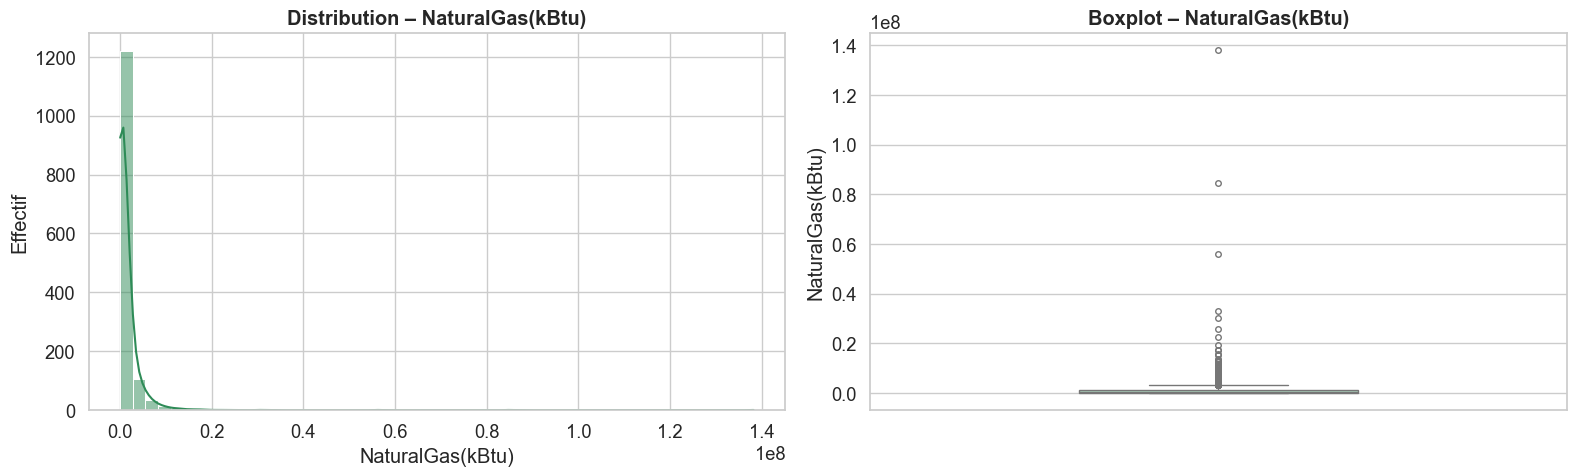


=== SiteEnergyUse(kBtu) ===
count: 1395.00
mean: 6642876.54
median: 2470566.00
min: 57133.20
max: 293090784.00
std: 16507399.21
skewness: 11.10
kurtosis: 168.96


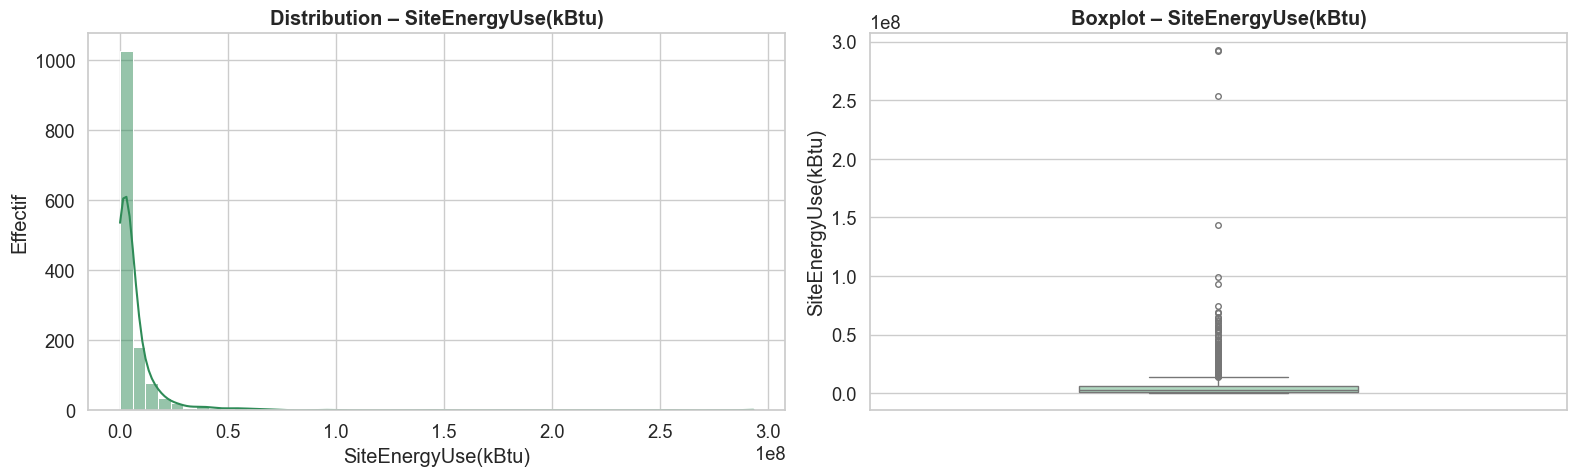


=== SiteEnergyUseWN(kBtu) ===
count: 1395.00
mean: 6817119.62
median: 2626698.25
min: 58114.20
max: 296671744.00
std: 16705632.22
skewness: 11.14
kurtosis: 170.11


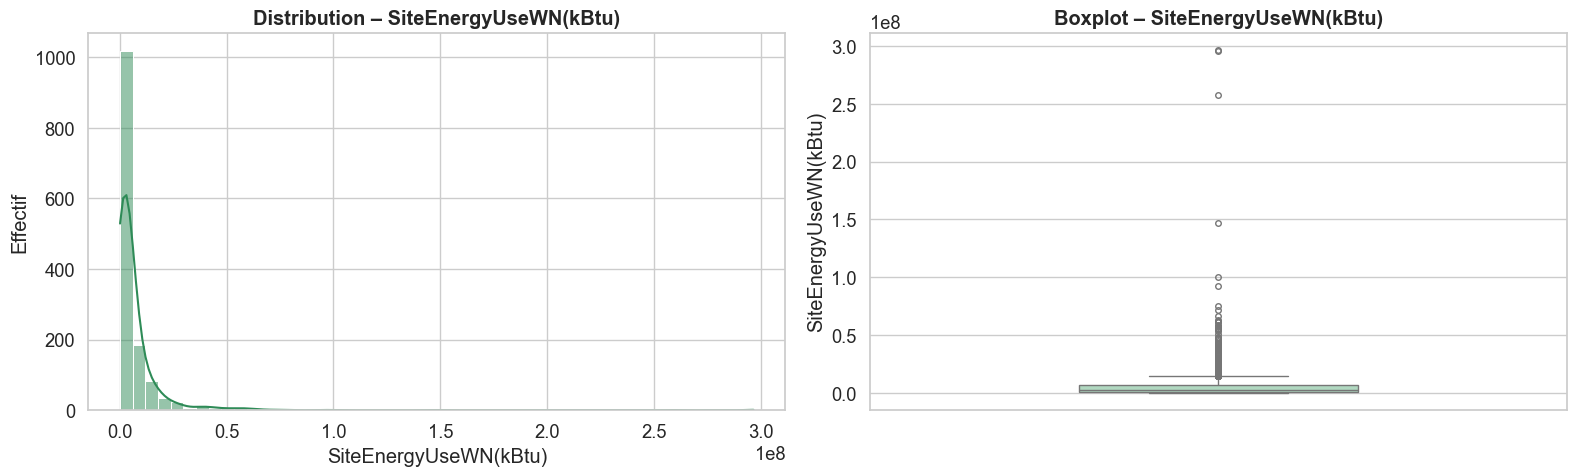


=== SiteEUI(kBtu/sf) ===
count: 1395.00
mean: 68.85
median: 52.40
min: 1.40
max: 696.70
std: 62.49
skewness: 3.01
kurtosis: 14.13


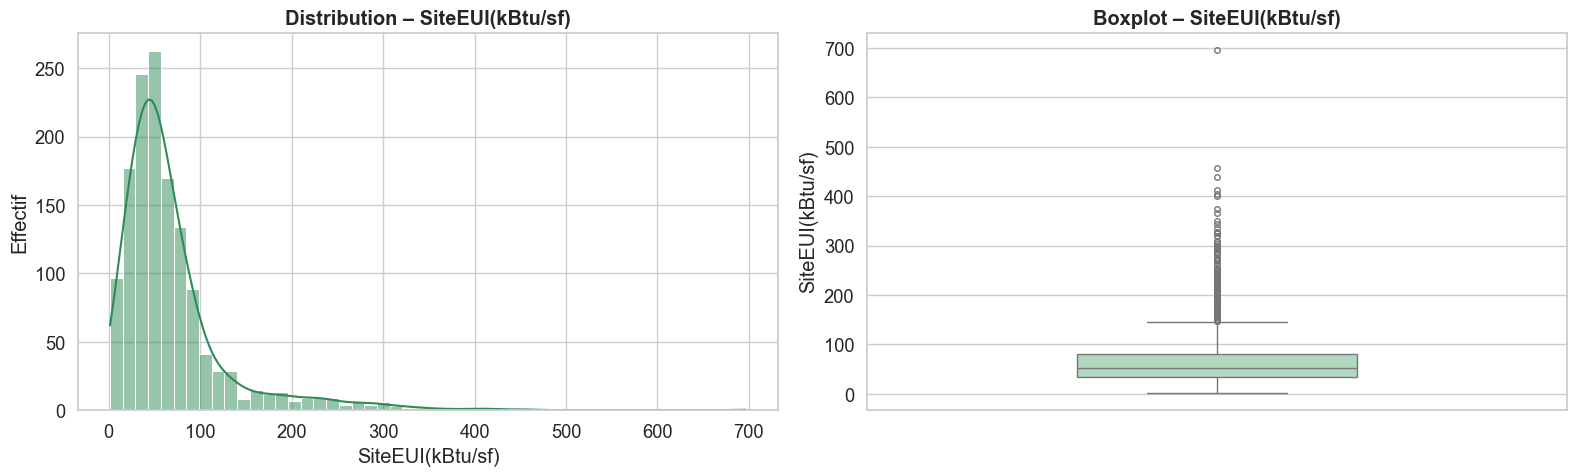


=== SiteEUIWN(kBtu/sf) ===
count: 1395.00
mean: 71.82
median: 54.44
min: 1.45
max: 671.94
std: 65.15
skewness: 2.93
kurtosis: 12.46


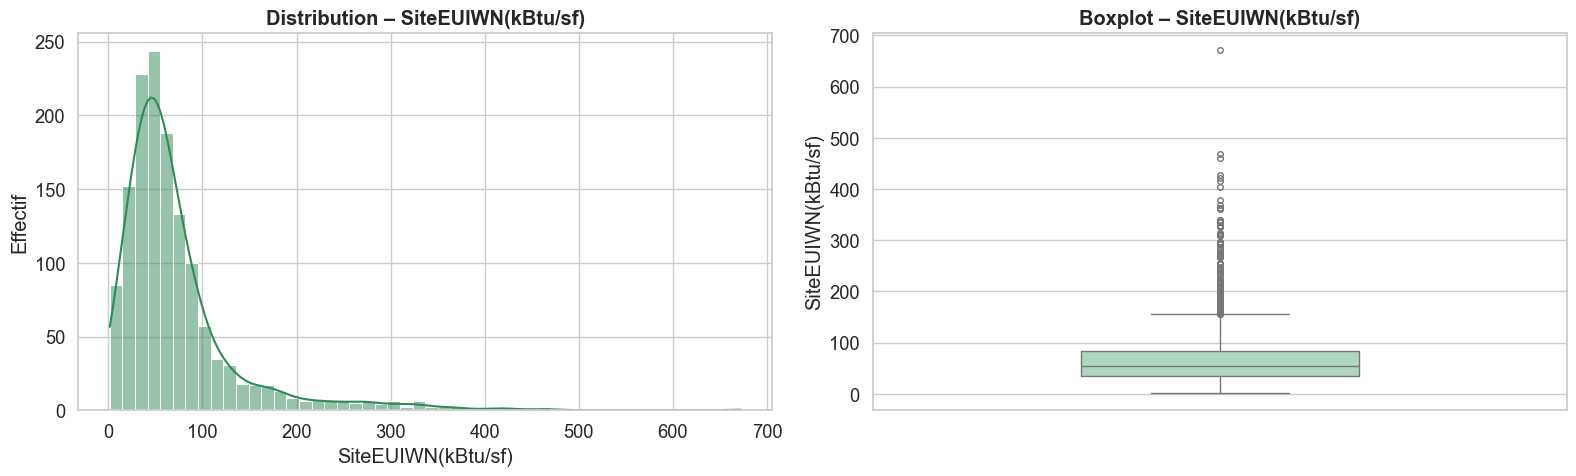


=== SourceEUI(kBtu/sf) ===
count: 1395.00
mean: 169.09
median: 136.00
min: 4.50
max: 1206.70
std: 142.83
skewness: 2.41
kurtosis: 8.18


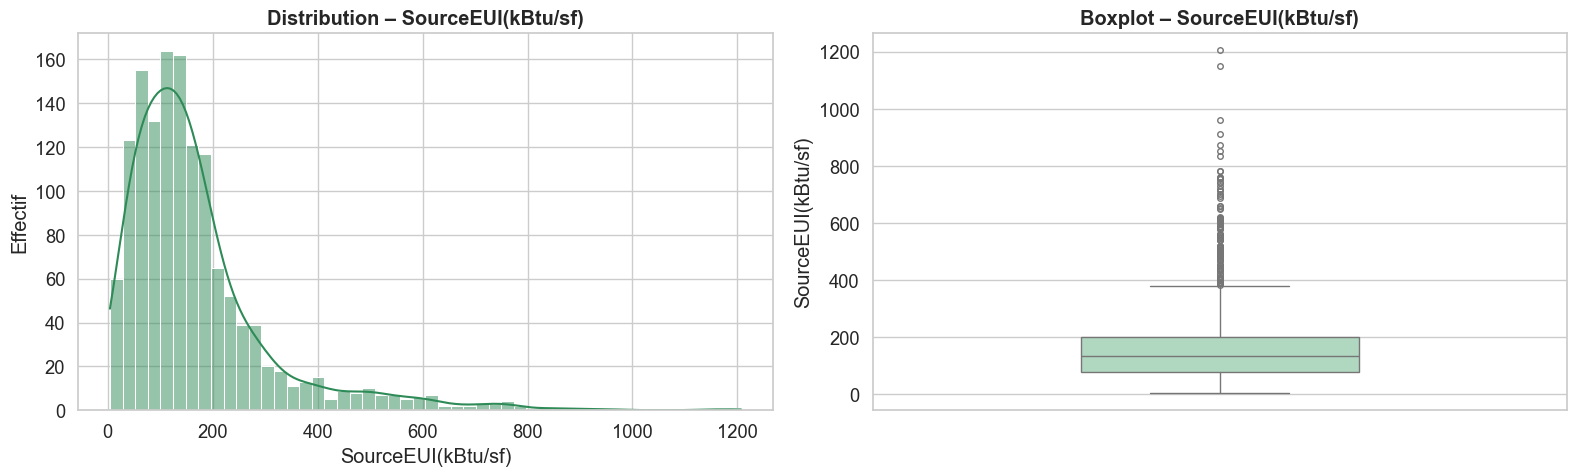


=== SourceEUIWN(kBtu/sf) ===
count: 1395.00
mean: 172.09
median: 138.40
min: 0.00
max: 1195.10
std: 143.11
skewness: 2.39
kurtosis: 8.00


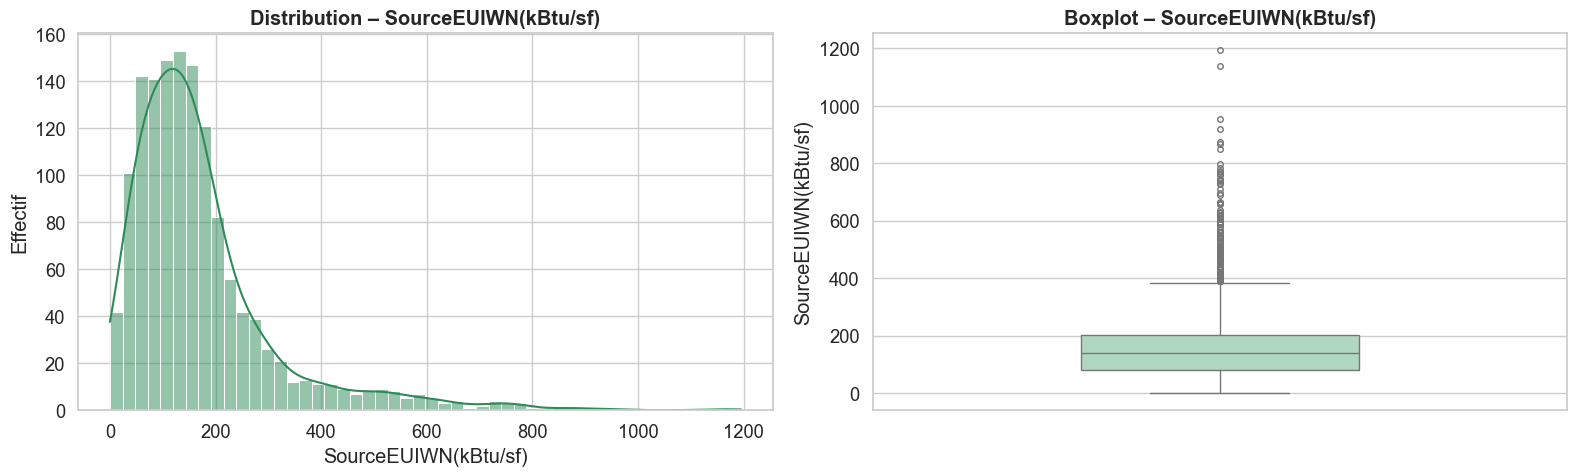

,variable,count,mean,median,min,max,std,skewness,kurtosis
0,SteamUse(kBtu),1395,361058.41,0.00,0.00,134943456.00,5019206.08,24.43,623.74
1,Electricity(kWh),1395,1414813.91,455209.59,0.00,49438336.00,3107765.77,7.09,76.10
2,Electricity(kBtu),1395,4827345.06,1553175.00,0.00,168683602.00,10603696.79,7.09,76.10
3,NaturalGas(therms),1395,14542.84,4248.65,0.00,1381912.38,52015.62,17.44,399.66
4,NaturalGas(kBtu),1395,1454283.98,424865.00,0.00,138191238.00,5201561.85,17.44,399.66
5,SiteEnergyUse(kBtu),1395,6642876.54,2470566.00,57133.20,293090784.00,16507399.21,11.10,168.96
6,SiteEnergyUseWN(kBtu),1395,6817119.62,2626698.25,58114.20,296671744.00,16705632.22,11.14,170.11
7,SiteEUI(kBtu/sf),1395,68.85,52.40,1.40,696.70,62.49,3.01,14.13
8,SiteEUIWN(kBtu/sf),1395,71.82,54.44,1.45,671.94,65.15,2.93,12.46
9,SourceEUI(kBtu/sf),1395,169.09,136.00,4.50,1206.70,142.83,2.41,8.18


In [152]:
# Analyse univariée – Variables énergétiques

# Couleurs
main_color = "#2E8B57"   # SeaGreen
box_color = "#A9DFBF"    # Light green

# Variables liées à l’énergie
energy_vars = [
    'SteamUse(kBtu)',
    'Electricity(kWh)',
    'Electricity(kBtu)',
    'NaturalGas(therms)',
    'NaturalGas(kBtu)',
    'SiteEnergyUse(kBtu)',
    'SiteEnergyUseWN(kBtu)',
    'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)'
]

# Paramètres généraux
sns.set(style="whitegrid", font_scale=1.2)
pd.set_option('display.float_format', '{:.2f}'.format)

# Tableau de synthèse
summary_rows = []

# Boucle sur les variables énergétiques
for col in energy_vars:
    data = df_raw[col].dropna()

    # Statistiques descriptives
    stats = {
        'variable': col,
        'count': data.count(),
        'mean': data.mean(),
        'median': data.median(),
        'min': data.min(),
        'max': data.max(),
        'std': data.std(),
        'skewness': data.skew(),
        'kurtosis': data.kurtosis()
    }

    summary_rows.append(stats)

    # Affichage console
    print(f"\n=== {col} ===")
    for k, v in stats.items():
        if k != 'variable':
            print(f"{k}: {v:.2f}")

    # Création figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Histogramme
    sns.histplot(
        data,
        bins=50,
        kde=True,
        color=main_color,
        ax=axes[0]
    )
    axes[0].set_title(f"Distribution – {col}", fontweight='bold')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Effectif")

    # Boxplot
    sns.boxplot(
        y=data,
        color=box_color,
        width=0.4,
        fliersize=4,
        ax=axes[1]
    )
    axes[1].set_title(f"Boxplot – {col}", fontweight='bold')
    axes[1].set_ylabel(col)

    plt.tight_layout()
    plt.show()

# Tableau récapitulatif
energy_summary_df = pd.DataFrame(summary_rows)

energy_summary_df


In [153]:
energy_summary_df.to_csv(
    "../reports/notebook_2/Energy_Variables_Summary.csv",
    index=False
)

### Analyse des variables WN (normalisées)

In [154]:
# Rechercher et afficher les variables WN

def cherche_colonnes(dataframe, suffix):
    liste = []
    for colonne in dataframe.columns:
        if suffix in colonne:
            liste.append(colonne)
    return liste

cherche_colonnes(df_raw, 'WN')

['SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)']

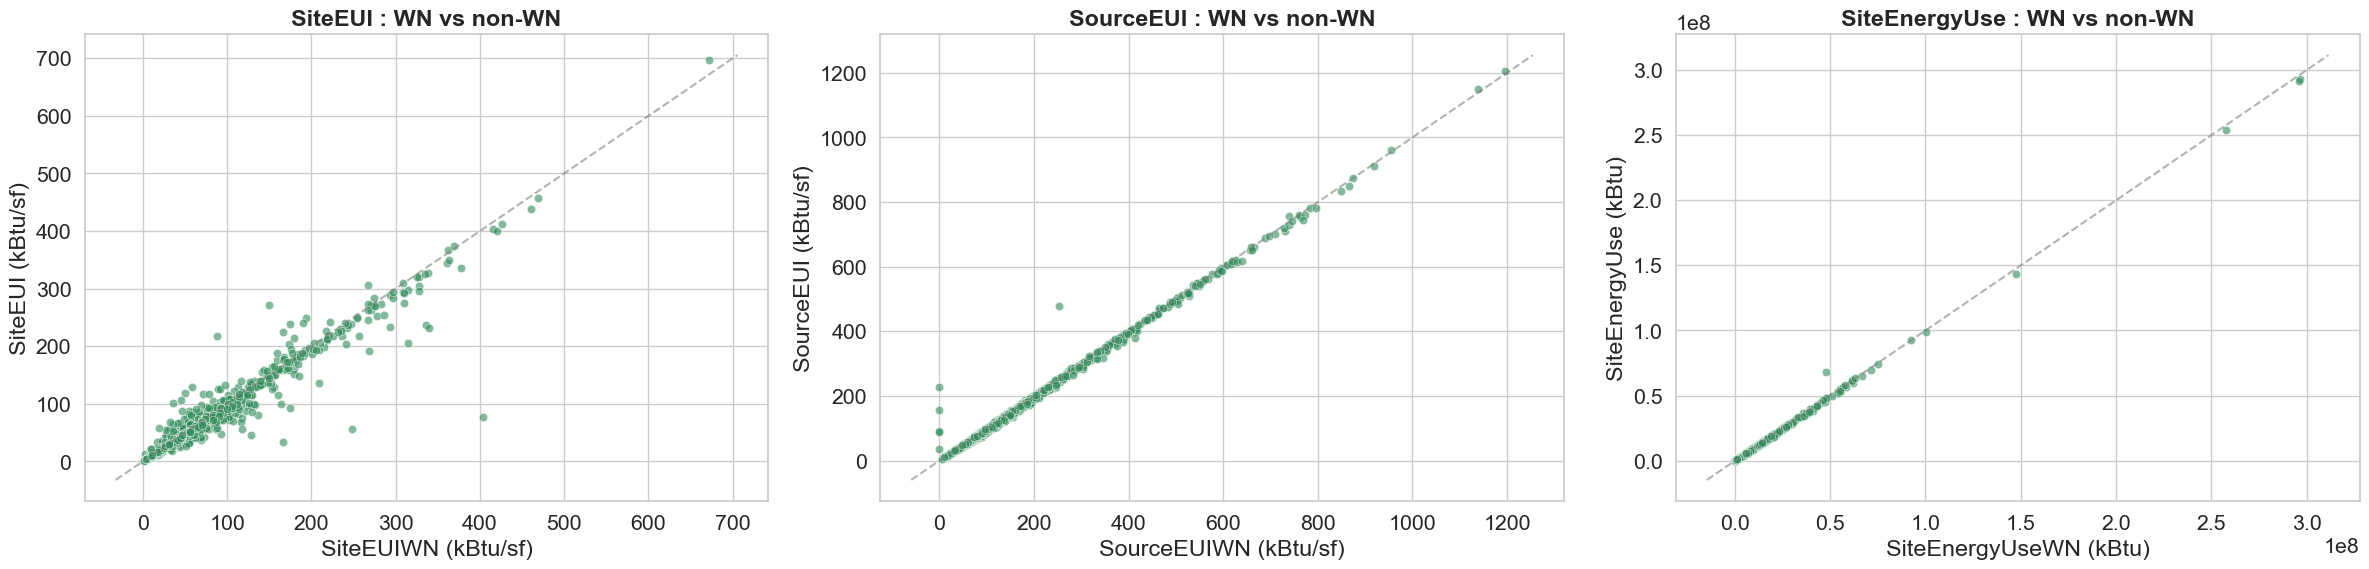

In [155]:
# Visualisations comparatives WN vs non-WN

# Couleurs
main_color = "#2E8B57"   # SeaGreen
box_color = "#A9DFBF"    # Light green

# Style global
sns.set(
    style="whitegrid",
    font_scale=1.4,
    rc={'figure.figsize': (24, 6)}
)

fig, axes = plt.subplots(nrows=1, ncols=3)

# --- Site EUI ---
sns.scatterplot(
    ax=axes[0],
    data=df_raw,
    x='SiteEUIWN(kBtu/sf)',
    y='SiteEUI(kBtu/sf)',
    color=main_color,
    alpha=0.6
)
axes[0].plot(axes[0].get_xlim(), axes[0].get_xlim(),
             linestyle="--", color="gray", alpha=0.6)
axes[0].set_title("SiteEUI : WN vs non-WN", fontweight="bold")
axes[0].set_xlabel("SiteEUIWN (kBtu/sf)")
axes[0].set_ylabel("SiteEUI (kBtu/sf)")

# --- Source EUI ---
sns.scatterplot(
    ax=axes[1],
    data=df_raw,
    x='SourceEUIWN(kBtu/sf)',
    y='SourceEUI(kBtu/sf)',
    color=main_color,
    alpha=0.6
)
axes[1].plot(axes[1].get_xlim(), axes[1].get_xlim(),
             linestyle="--", color="gray", alpha=0.6)
axes[1].set_title("SourceEUI : WN vs non-WN", fontweight="bold")
axes[1].set_xlabel("SourceEUIWN (kBtu/sf)")
axes[1].set_ylabel("SourceEUI (kBtu/sf)")

# --- Site Energy Use ---
sns.scatterplot(
    ax=axes[2],
    data=df_raw,
    x='SiteEnergyUseWN(kBtu)',
    y='SiteEnergyUse(kBtu)',
    color=main_color,
    alpha=0.6
)
axes[2].plot(axes[2].get_xlim(), axes[2].get_xlim(),
             linestyle="--", color="gray", alpha=0.6)
axes[2].set_title("SiteEnergyUse : WN vs non-WN", fontweight="bold")
axes[2].set_xlabel("SiteEnergyUseWN (kBtu)")
axes[2].set_ylabel("SiteEnergyUse (kBtu)")

plt.tight_layout()
plt.show()

Les nuages de points comparant les variables normalisées météo (WN) à leurs équivalents non normalisés révèlent une **relation quasi parfaitement linéaire**, avec une concentration très marquée des observations autour de la diagonale \(y = x\). Cette structure indique une **corrélation extrêmement élevée** entre chaque paire de variables (SiteEUI, SourceEUI et SiteEnergyUse), suggérant que la normalisation climatique n’introduit qu’un ajustement marginal sans modifier substantiellement l’information contenue dans les données.

Dans ce contexte, l’utilisation simultanée des versions WN et non-WN serait redondante et pourrait introduire des problèmes de **multicolinéarité** dans les modèles. Par conséquent, il est **justifié de se passer des variables normalisées météo (WN)** et de conserver uniquement les versions non normalisées, plus simples à interpréter et suffisantes pour la phase de modélisation.

## Section 4 : Caractéristiques physiques des bâtiments

Cette section est consacrée à l’analyse univariée des **caractéristiques physiques des bâtiments**, décrivant leur taille, leur configuration spatiale et leur structure verticale. L’objectif est de mieux comprendre la morphologie du parc immobilier étudié et d’identifier les éléments structurels susceptibles d’influencer la consommation énergétique et les émissions de gaz à effet de serre.

### Objectifs principaux
1. **Explorer individuellement** les variables décrivant les caractéristiques physiques des bâtiments afin d’identifier la taille et la configuration typiques au sein du dataset.
2. **Analyser les distributions statistiques** des surfaces (PropertyGFATotal, PropertyGFABuilding(s), PropertyGFAParking etc) à l’aide de statistiques descriptives (moyenne, médiane, écart-type, minimum, maximum) et de visualisations adaptées.
3. **Étudier la structure verticale des bâtiments** à travers la variable *NumberofFloors*, afin d’identifier les configurations dominantes et la répartition du nombre d’étages.
4. **Identifier les caractéristiques problématiques**, telles que des distributions fortement asymétriques, la présence de bâtiments de très grande taille ou une hétérogénéité marquée entre observations.
5. **Préparer la phase de Machine Learning** en réfléchissant à des indicateurs pertinents issus de ces variables (normalisation par la surface, ratios surface/étages, transformation logarithmique), utiles pour la modélisation.

### Dépendances critiques
Les bibliothèques suivantes sont utilisées pour cette analyse :
- **pandas, numpy** : manipulation des données et calcul des statistiques descriptives  
- **matplotlib, seaborn** : visualisation des distributions et détection graphique des valeurs aberrantes  

### Livrables
1. **Tableau des statistiques descriptives** pour chaque variable physique des bâtiments  
   (moyenne, médiane, écart-type, minimum, maximum).
2. **Graphiques de distribution univariés**  
   - histogrammes pour analyser la distribution des surfaces,  
   - boxplots pour identifier la dispersion et les valeurs aberrantes,  
   - barplots pour la distribution du nombre d’étages.
3. **Synthèse analytique** mettant en évidence :
   - la taille typique des bâtiments,
   - la proportion des surfaces de stationnement,
   - les transformations ou indicateurs dérivés recommandés pour la modélisation.


=== NumberofBuildings ===
count: 1395.00
mean: 1.11
median: 1.00
min: 0.00
max: 27.00
std: 1.20
skewness: 13.99
kurtosis: 249.91


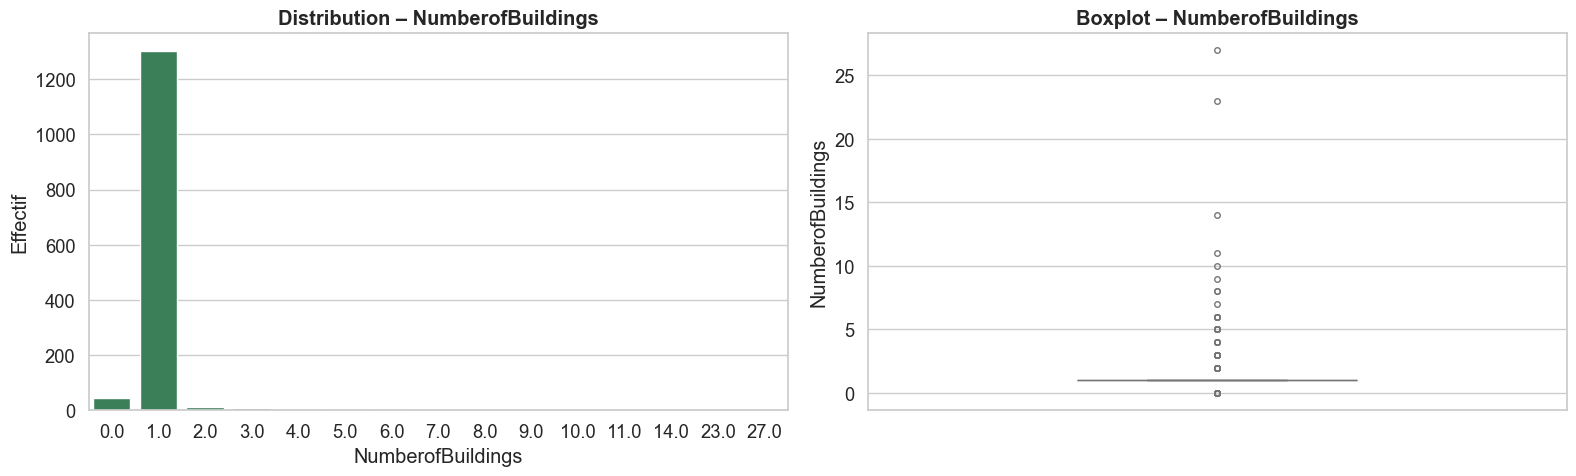


=== NumberofFloors ===
count: 1395.00
mean: 4.28
median: 2.00
min: 1.00
max: 99.00
std: 6.87
skewness: 5.98
kurtosis: 50.87


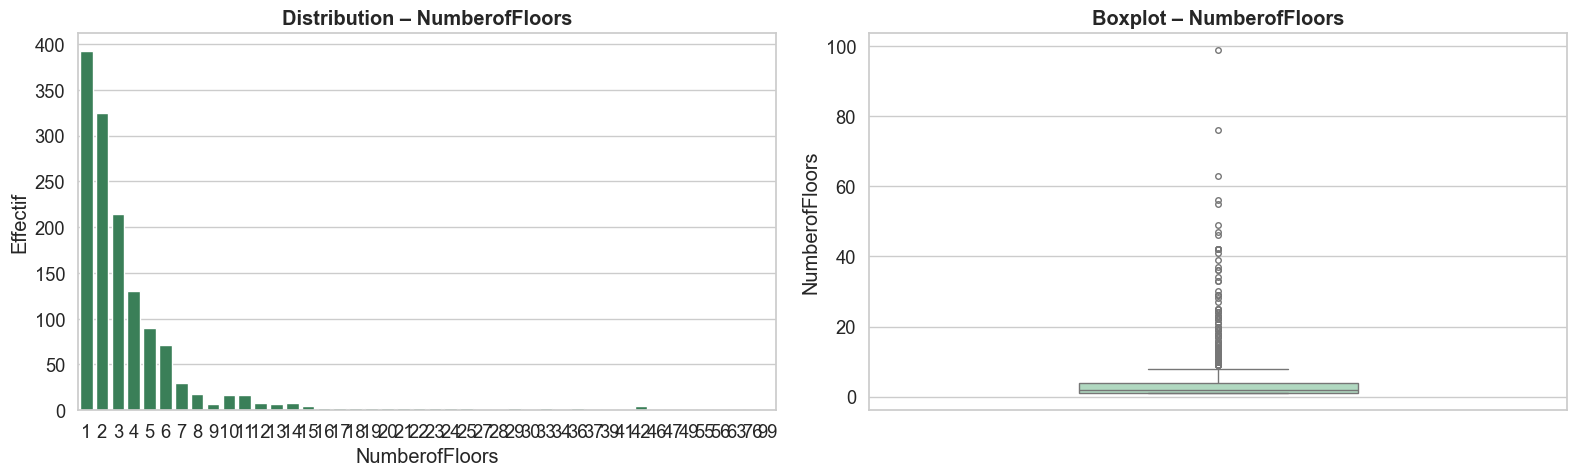


=== PropertyGFATotal ===
count: 1395.00
mean: 108866.42
median: 46059.00
min: 11285.00
max: 1952220.00
std: 189146.12
skewness: 4.92
kurtosis: 30.79


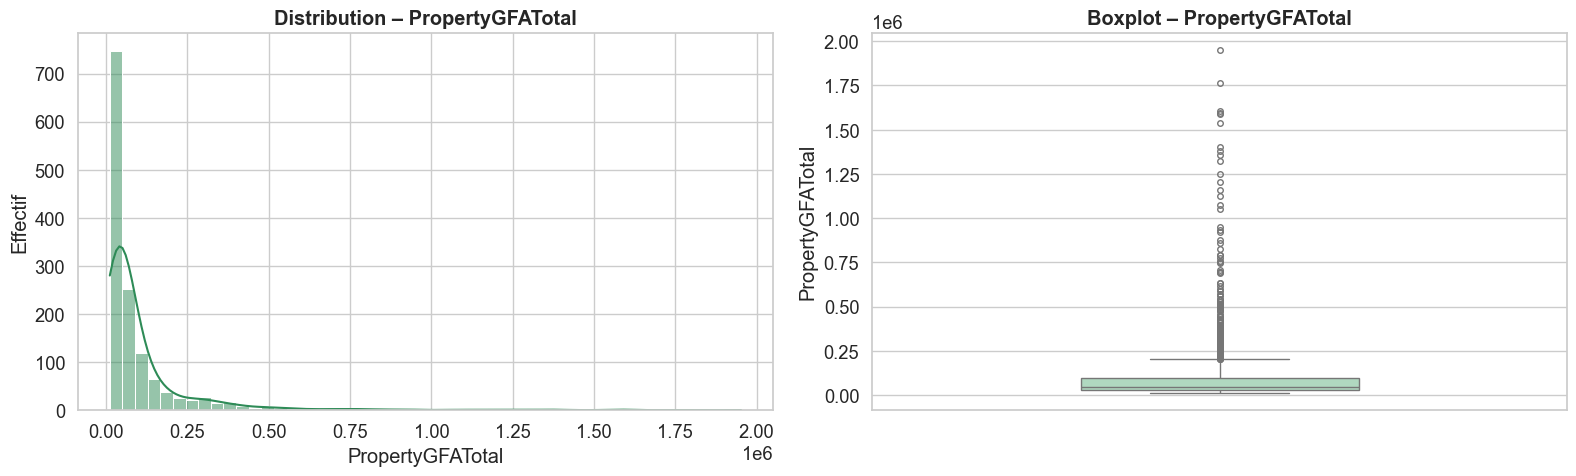


=== PropertyGFAParking ===
count: 1395.00
mean: 13896.07
median: 0.00
min: 0.00
max: 512608.00
std: 44653.82
skewness: 5.08
kurtosis: 33.06


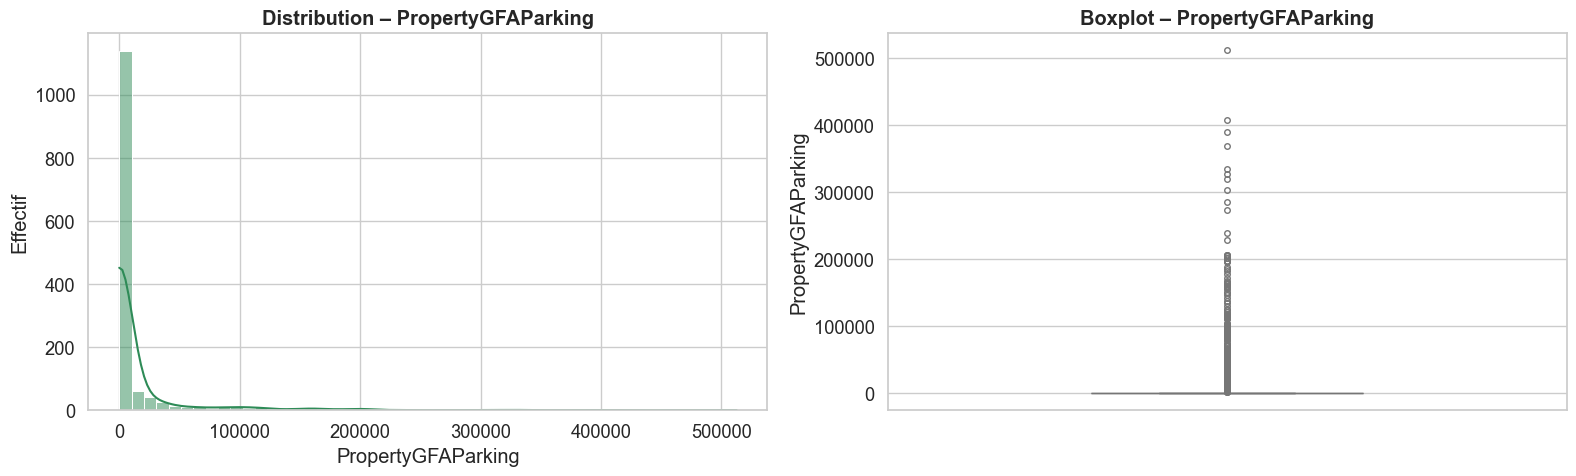


=== PropertyGFABuilding(s) ===
count: 1395.00
mean: 94970.35
median: 44719.00
min: 10925.00
max: 1765970.00
std: 164001.35
skewness: 5.23
kurtosis: 34.63


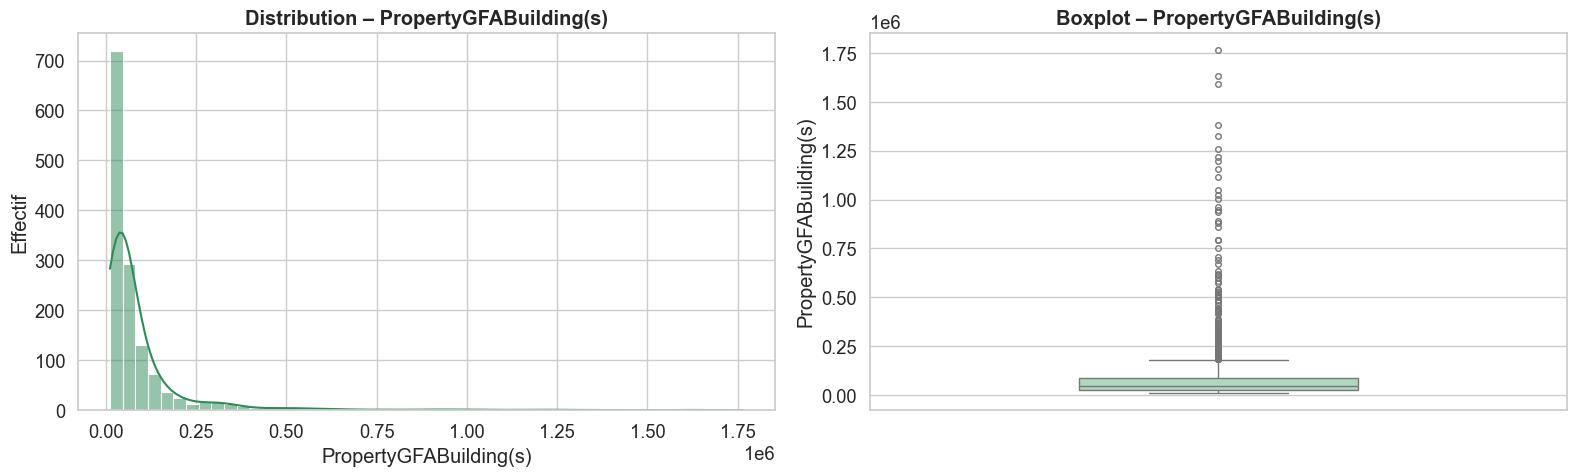

,variable,count,mean,median,min,max,std,skewness,kurtosis
0,NumberofBuildings,1395,1.11,1.00,0.00,27.00,1.20,13.99,249.91
1,NumberofFloors,1395,4.28,2.00,1.00,99.00,6.87,5.98,50.87
2,PropertyGFATotal,1395,108866.42,46059.00,11285.00,1952220.00,189146.12,4.92,30.79
3,PropertyGFAParking,1395,13896.07,0.00,0.00,512608.00,44653.82,5.08,33.06
4,PropertyGFABuilding(s),1395,94970.35,44719.00,10925.00,1765970.00,164001.35,5.23,34.63


In [156]:
# Analyse univariée – Caractéristiques physiques des bâtiments


# Couleurs
main_color = "#2E8B57"   # SeaGreen
box_color = "#A9DFBF"    # Light green

# Variables physiques des bâtiments
physical_vars = [
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)'
]

# Paramètres généraux
sns.set(style="whitegrid", font_scale=1.2)
pd.set_option('display.float_format', '{:.2f}'.format)

# Tableau de synthèse
physical_summary_rows = []

# Boucle sur les variables physiques
for col in physical_vars:
    data = df_raw[col].dropna()

    # Statistiques descriptives
    stats = {
        'variable': col,
        'count': data.count(),
        'mean': data.mean(),
        'median': data.median(),
        'min': data.min(),
        'max': data.max(),
        'std': data.std(),
        'skewness': data.skew(),
        'kurtosis': data.kurtosis()
    }

    physical_summary_rows.append(stats)

    # Affichage console
    print(f"\n=== {col} ===")
    for k, v in stats.items():
        if k != 'variable':
            print(f"{k}: {v:.2f}")

    # Création figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Histogramme (ou barplot si variable discrète)
    if col in ['NumberofBuildings', 'NumberofFloors']:
        sns.countplot(
            x=data,
            color=main_color,
            ax=axes[0]
        )
        axes[0].set_ylabel("Effectif")
    else:
        sns.histplot(
            data,
            bins=50,
            kde=True,
            color=main_color,
            ax=axes[0]
        )
        axes[0].set_ylabel("Effectif")

    axes[0].set_title(f"Distribution – {col}", fontweight='bold')
    axes[0].set_xlabel(col)

    # Boxplot
    sns.boxplot(
        y=data,
        color=box_color,
        width=0.4,
        fliersize=4,
        ax=axes[1]
    )
    axes[1].set_title(f"Boxplot – {col}", fontweight='bold')
    axes[1].set_ylabel(col)

    plt.tight_layout()
    plt.show()

# Tableau récapitulatif
physical_summary_df = pd.DataFrame(physical_summary_rows)

physical_summary_df

In [157]:
physical_summary_df.to_csv(
    "../reports/notebook_2/Physical_Variables_Summary.csv",
    index=False
)

## Section 5 : Dimension temporelle – `YearBuilt`

Cette section est consacrée à l’analyse univariée de la **dimension temporelle** du parc immobilier à travers la variable **YearBuilt**, qui renseigne sur l’année de construction des bâtiments. Cette variable permet de contextualiser l’évolution historique du bâti et d’identifier des périodes de construction dominantes, susceptibles d’être associées à des normes architecturales et énergétiques différentes.

### Objectifs principaux
1. **Explorer la distribution temporelle** des bâtiments afin d’identifier les périodes de construction les plus représentées dans le dataset.
2. **Analyser les statistiques descriptives** de l’année de construction (minimum, maximum, médiane) pour caractériser l’ancienneté typique des bâtiments.
3. **Identifier d’éventuelles valeurs atypiques**, telles que des bâtiments très anciens ou très récents, pouvant influencer les analyses ultérieures.
4. **Préparer la phase de modélisation** en évaluant la pertinence de transformations ou de regroupements temporels (par classes d’âge des bâtiments).

### Dépendances critiques
Les bibliothèques suivantes sont utilisées pour cette analyse :
- **pandas, numpy** : manipulation des données et calcul des statistiques descriptives  
- **matplotlib, seaborn** : visualisation des distributions temporelles  

### Analyses réalisées
- **Statistiques descriptives** de la variable *YearBuilt* (minimum, maximum, médiane).
- **Histogramme de distribution** des années de construction afin d’identifier les périodes dominantes.
- **Regroupement en classes d’âge** (bâtiments récents, intermédiaires, anciens) pour faciliter l’interprétation.

### Observations attendues
- Une concentration des constructions sur certaines périodes historiques.
- La présence de bâtiments anciens, reflétant l’héritage urbain, ainsi que de bâtiments plus récents intégrant potentiellement des normes énergétiques plus strictes.

### Livrables
1. **Tableau des statistiques descriptives** de la variable *YearBuilt*.  
2. **Histogramme de distribution** des années de construction.  
3. **Synthèse analytique** mettant en évidence la structure temporelle du parc immobilier et ses implications potentielles pour la consommation énergétique et la modélisation.

In [158]:
# Création de la colonne BuildingAge (Age des bâtiments)
current_year = 2016 
df_raw['BuildingAge'] = current_year - df_raw['YearBuilt']

print(f"Nombre de bâtiments : {df_raw['BuildingAge'].nunique()}")
print(f"Le bâtiment le plus vieux a {df_raw['BuildingAge'].max()} ans.")
print(f"Le bâtiment le plus jeune a {df_raw['BuildingAge'].min()} ans.")

Nombre de bâtiments : 113
Le bâtiment le plus vieux a 116 ans.
Le bâtiment le plus jeune a 1 ans.


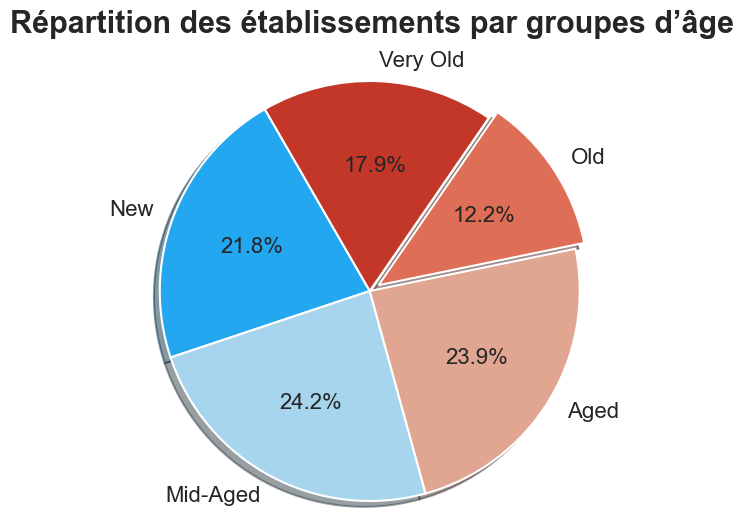

In [179]:
# Création des groupes d’âge

df_raw["AgeGroup"] = pd.cut(
    df_raw["BuildingAge"],
    bins=5,
    precision=0,
    labels=["New", "Mid-Aged", "Aged", "Old", "Very Old"]
)

# Supprimer les NA pour le graphique
age_counts = df_raw["AgeGroup"].dropna().value_counts().sort_index()

# Palette de couleurs

colors = {
    "New": "#22a7f0",
    "Mid-Aged": "#a7d5ed",
    "Aged": "#e1a692",
    "Old": "#de6e56",
    "Very Old": "#c23728"
}

# Figure

fig, ax = plt.subplots(figsize=(8 , 6))

ax.set_title(
    "Répartition des établissements par groupes d’âge",
    fontsize=22,
    fontweight="bold",
    pad=20
)

# Pie chart
ax.pie(
    age_counts,
    labels=age_counts.index,
    autopct="%1.1f%%",
    explode=[0, 0, 0, 0.05, 0],
    colors=[colors[g] for g in age_counts.index],
    shadow=True,
    startangle=120,
    textprops={"fontsize": 16}
)

ax.axis("equal")  # Cercle parfait
plt.show()

La répartition des batiments par groupes d’âge met en évidence une structure relativement équilibrée du parc immobilier étudié. Les bâtiments **d’âge intermédiaire (Mid-Aged)** et **anciens (Aged)** constituent les catégories majoritaires, représentant respectivement **24.2 %** et **23.9 %** des établissements, ce qui indique que près de la moitié du parc a été construit durant des périodes intermédiaires. Les bâtiments **récents (New)** représentent **21.8 %**, traduisant une part non négligeable de constructions plus modernes, tandis que les bâtiments **très anciens (Very Old)** comptent pour **17.9 %**, reflétant la persistance d’un patrimoine bâti ancien. Enfin, la catégorie **Old** est la moins représentée (**12.2 %**), ce qui suggère une transition progressive entre les bâtiments intermédiaires et les plus anciens. Cette distribution souligne une forte hétérogénéité de l’âge des bâtiments, facteur clé à considérer dans l’analyse des performances énergétiques et des émissions de GES.

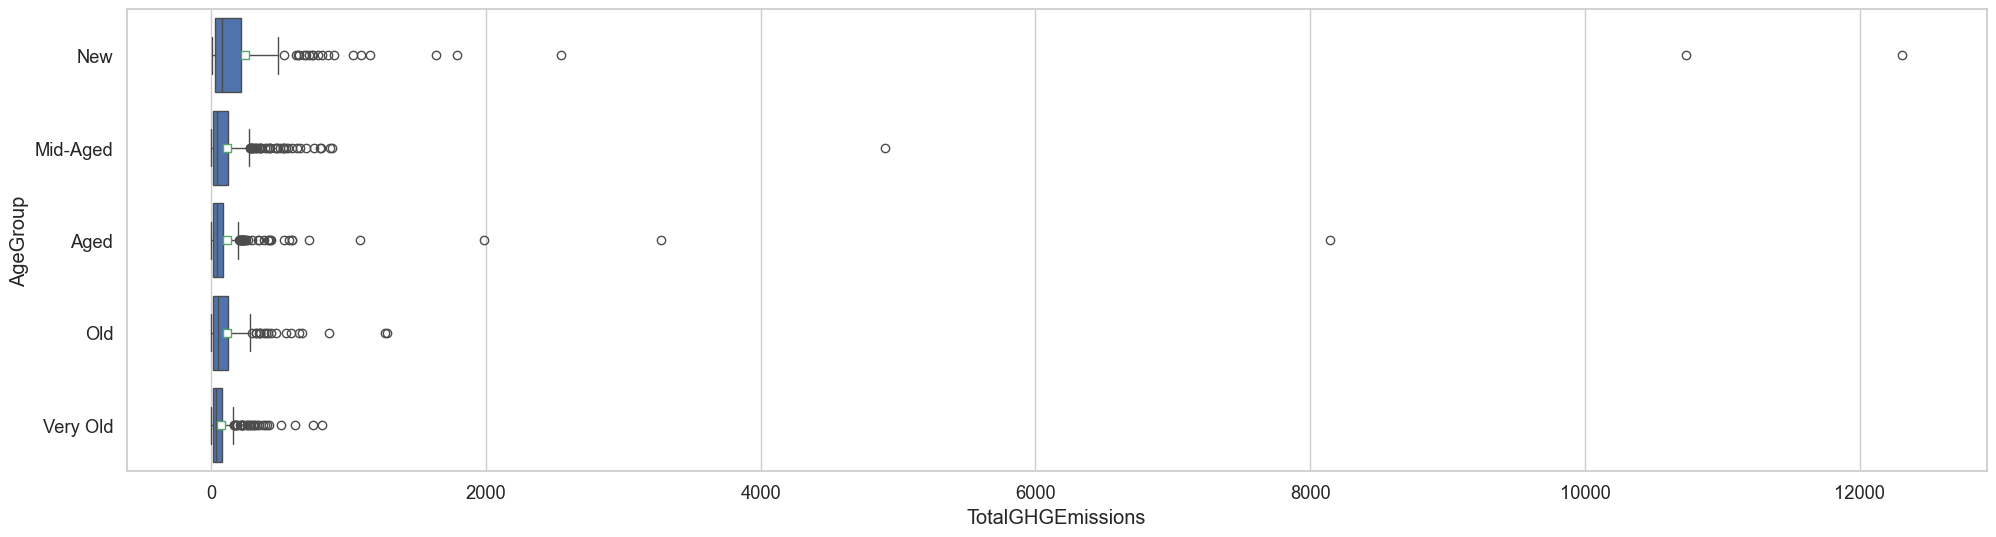

In [160]:
sns.boxplot(y=df_raw['AgeGroup'],
            x=df_raw['TotalGHGEmissions'],
            data=df_raw[df_raw['TotalGHGEmissions'] != np.nan],
            saturation=0.9,
            order=["New", "Mid-Aged", "Aged", "Old", 'Very Old'],
            showmeans=True,
            meanprops={
                "marker": "s",
                "markerfacecolor": "white"
            }
            #color='darkred'
            )

plt.show()

Le boxplot des émissions de GES par groupes d’âge révèle une forte asymétrie à droite dans toutes les catégories, avec une majorité d’établissements faiblement émetteurs et quelques valeurs extrêmes très élevées. La présence d’outliers dans tous les groupes indique que l’âge du bâtiment seul n’explique pas les émissions extrêmes et qu’une transformation logarithmique ainsi que l’intégration d’autres variables explicatives sont nécessaires.

## Section 6 : Performance énergétique – `ENERGYSTARScore`

Cette section est dédiée à l’analyse univariée de la **performance énergétique des bâtiments** à travers la variable **ENERGYSTARScore**, un indicateur synthétique compris entre 0 et 100, où une valeur élevée reflète une meilleure efficacité énergétique. Cette variable permet d’évaluer le positionnement énergétique relatif des bâtiments et d’identifier les établissements certifiés par le programme ENERGY STAR.

### Objectifs principaux
1. **Analyser la distribution du score ENERGYSTAR** afin d’évaluer le niveau global de performance énergétique des bâtiments certifiés.
2. **Caractériser statistiquement les bâtiments certifiés uniquement**, en étudiant les statistiques descriptives du score (moyenne, médiane, dispersion).
3. **Préparer la phase de modélisation** en évaluant la pertinence de cette variable comme cible secondaire, variable explicative ou indicateur de performance.

### Dépendances critiques
Les bibliothèques suivantes sont utilisées pour cette analyse :
- **pandas, numpy** : manipulation des données, gestion des valeurs manquantes et calcul des statistiques descriptives  
- **matplotlib, seaborn** : visualisation de la distribution du score et détection des asymétries  

### Analyses réalisées
- **Histogramme et boxplot** du score ENERGYSTAR pour les bâtiments disposant d’une valeur valide.
- **Statistiques descriptives** du score ENERGYSTAR pour les bâtiments disposant d’une valeur valide.

### Observations attendues
- Une distribution du score potentiellement asymétrique, avec une concentration autour de valeurs intermédiaires à élevées.
- Une variabilité du score reflétant l’hétérogénéité des performances énergétiques au sein du parc immobilier.

### Livrables
1. **Statistiques descriptives du score ENERGYSTAR** pour les bâtiments.  
2. **Visualisations univariées** (histogramme et boxplot) du score.  
3. **Synthèse analytique** mettant en évidence le niveau global de performance énergétique, la part des bâtiments non certifiés et les implications pour la modélisation.

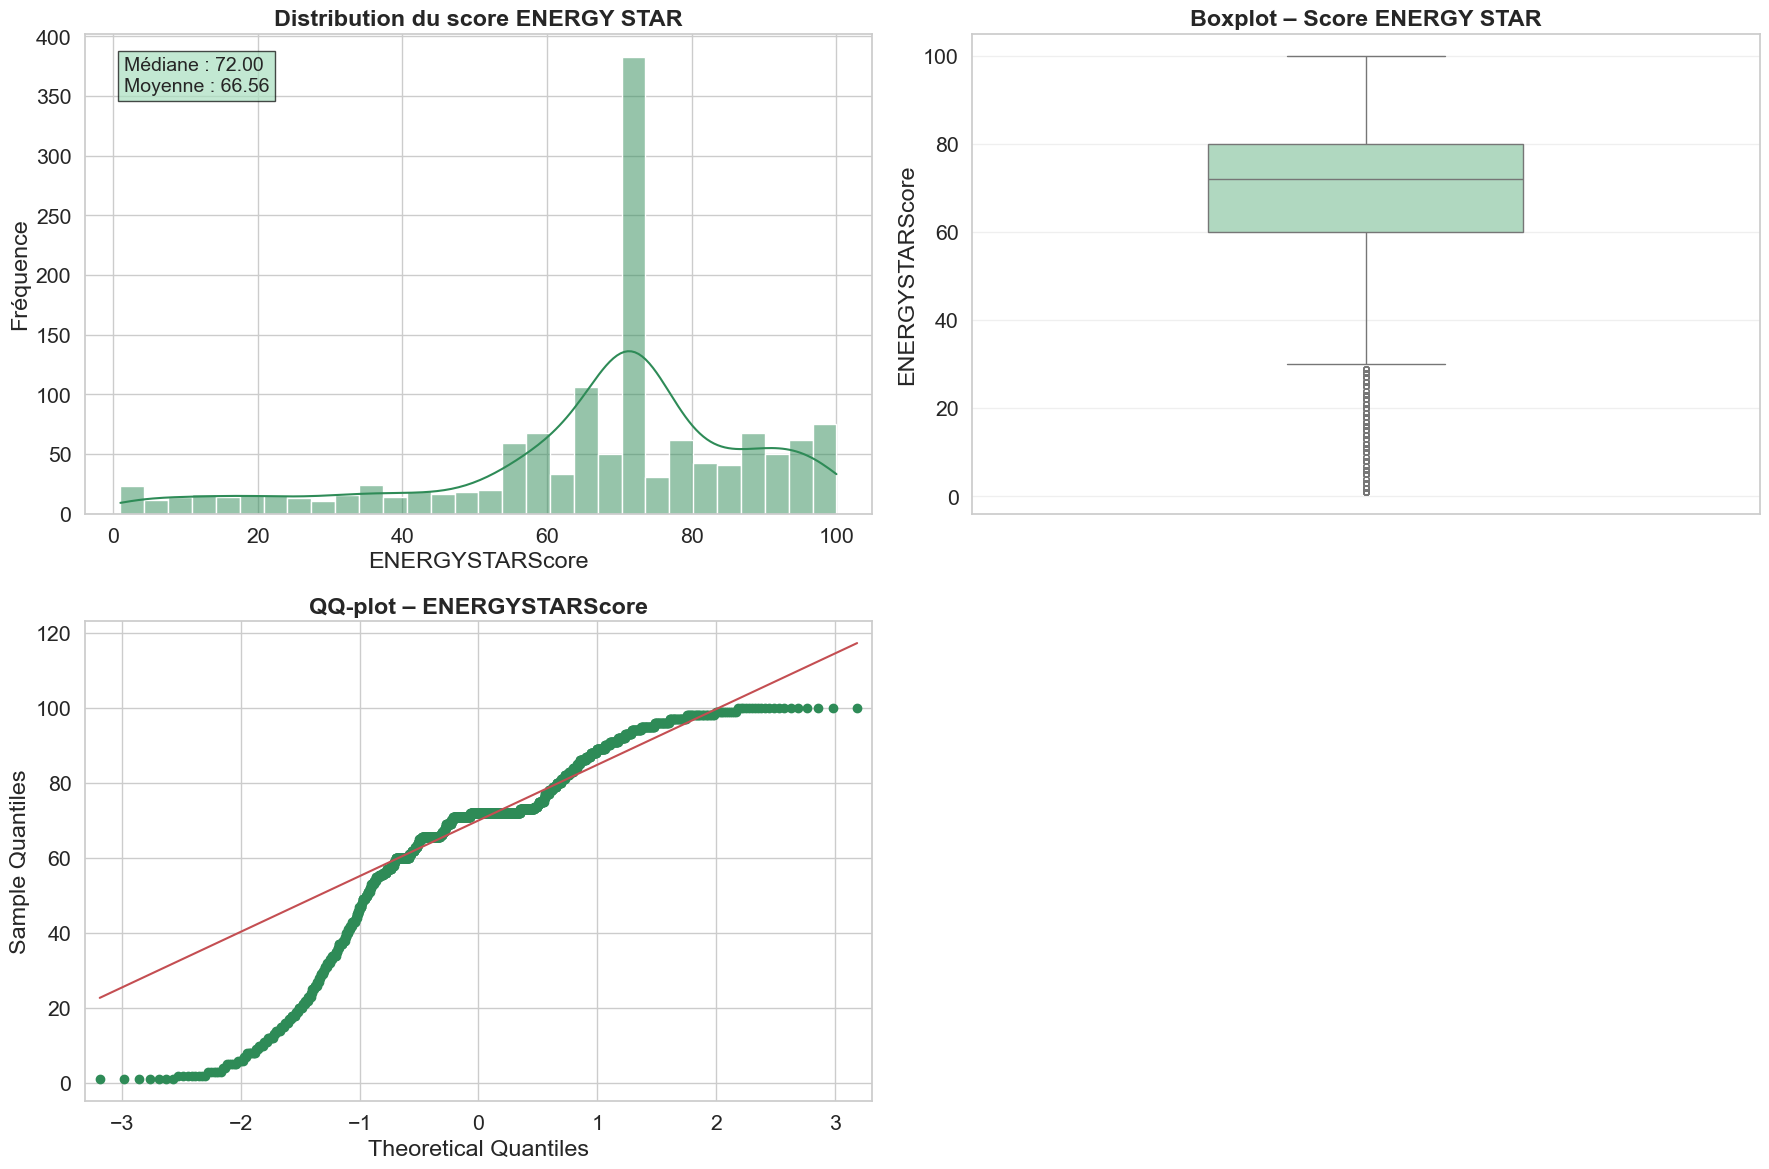

In [208]:
main_color = "#2E8B57"   # SeaGreen
box_color  = "#A9DFBF"   # Light green

sns.set(
    rc={'figure.figsize': (18, 12)},
    font_scale=1.4,
    style="whitegrid"
)

fig, axes = plt.subplots(2, 2)

# Histogramme (haut gauche)

sns.histplot(
    df_raw,
    x='ENERGYSTARScore',
    kde=True,
    bins=30,
    color=main_color,
    ax=axes[0, 0]
)

axes[0, 0].text(
    0.05, 0.88,
    f"Médiane : {df_raw['ENERGYSTARScore'].median():.2f}\n"
    f"Moyenne : {df_raw['ENERGYSTARScore'].mean():.2f}",
    transform=axes[0, 0].transAxes,
    fontsize=14,
    bbox=dict(facecolor=box_color, alpha=0.7, edgecolor='black')
)

axes[0, 0].set_title("Distribution du score ENERGY STAR", fontweight='bold')
axes[0, 0].set_xlabel("ENERGYSTARScore")
axes[0, 0].set_ylabel("Fréquence")

# Boxplot (haut droite)

sns.boxplot(
    y=df_raw['ENERGYSTARScore'],
    ax=axes[0, 1],
    color=box_color,
    width=0.4,
    fliersize=4
)

axes[0, 1].set_title("Boxplot – Score ENERGY STAR", fontweight='bold')
axes[0, 1].set_ylabel("ENERGYSTARScore")
axes[0, 1].grid(axis='y', alpha=0.3)

# QQ-plot (bas gauche)

sm.qqplot(
    df_raw['ENERGYSTARScore'].dropna(),
    line='q',
    ax=axes[1, 0],
    markerfacecolor=main_color,
    markeredgecolor=main_color
)

axes[1, 0].set_title("QQ-plot – ENERGYSTARScore", fontweight='bold')


axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

In [162]:
# Tests de normalité sur la variable ENERGYSTARScore

target_0 = df_raw['ENERGYSTARScore'].dropna()

alpha = 0.05


# Fonction d'interprétation

def interpret_test(p_value, alpha=0.05):
    return "Distribution compatible avec la normalité (H0 non rejetée)" \
        if p_value > alpha else "Distribution non normale (H0 rejetée)"


# D’Agostino-Pearson (normaltest)
print("\n" + "=" * 60)
stat, p = normaltest(target)
print("ENERGYSTARScore Agostino-Pearson")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)


# Shapiro

if len(target) < 5000:
    stat, p = shapiro(target)
    print("ENERGYSTARScore Shapiro")
    print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
    print(interpret_test(p))
else:
    print("Shapiro non exécuté : échantillon trop grand (>5000)")
print("=" * 60)


# Kolmogorov–Smirnov

# On compare avec la distribution normale standardisée
target_std = (target - target.mean()) / target.std()
stat, p = kstest(target_std, 'norm')
print("ENERGYSTARScore Kolmogorov–Smirnov")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)


# Jarque-Bera

stat, p = jarque_bera(target)
print("ENERGYSTARScore Jarque-Bera")
print(f"Statistic = {stat:.3f}, p-value = {p:.3e}")
print(interpret_test(p))
print("=" * 60)


ENERGYSTARScore Agostino-Pearson
Statistic = 2881.787, p-value = 0.000e+00
Distribution non normale (H0 rejetée)
ENERGYSTARScore Shapiro
Statistic = 0.164, p-value = 2.211e-61
Distribution non normale (H0 rejetée)
ENERGYSTARScore Kolmogorov–Smirnov
Statistic = 0.399, p-value = 7.266e-201
Distribution non normale (H0 rejetée)
ENERGYSTARScore Jarque-Bera
Statistic = 6312903.384, p-value = 0.000e+00
Distribution non normale (H0 rejetée)


### ENERGYSTARSCORE et TotalGHGEmissions

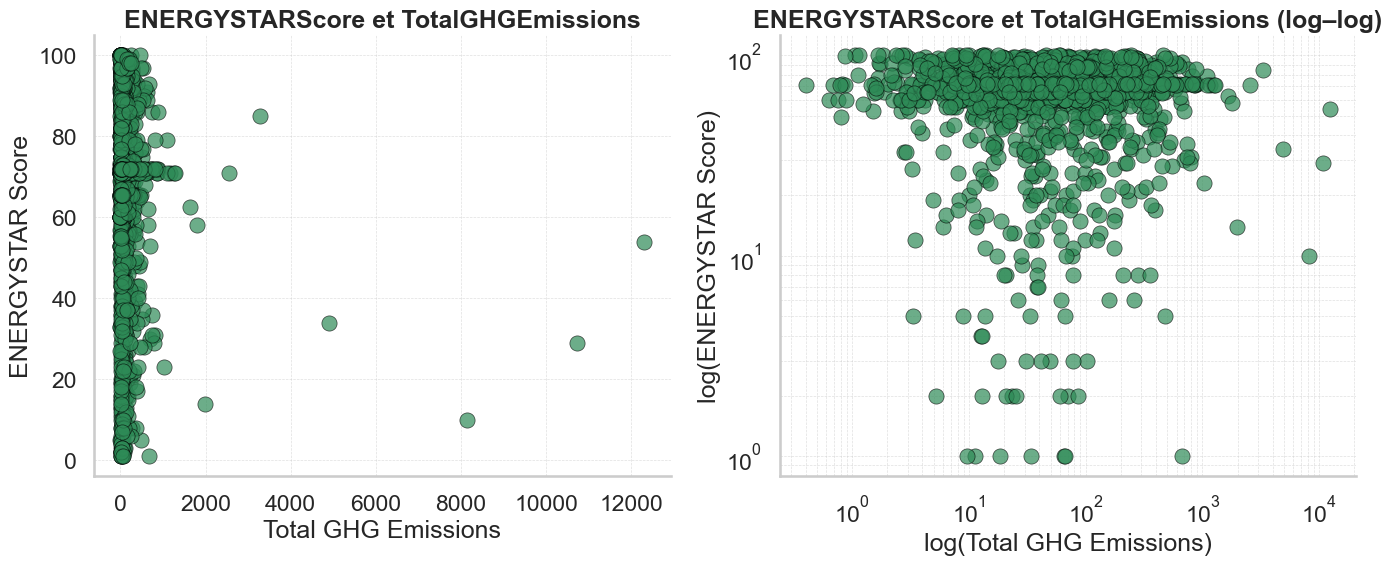

In [163]:
# Couleurs
main_color = "#2E8B57"  # SeaGreen

sns.set_theme(
    style="whitegrid",
    context="talk",
    rc={"figure.figsize": (14, 6)}
)
# Figure
fig, axes = plt.subplots(1, 2, sharey=False)


# Échelle normale

sns.scatterplot(
    x="TotalGHGEmissions",
    y="ENERGYSTARScore",
    data=df_raw,
    s=120,
    color=main_color,
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
    ax=axes[0]
)

axes[0].set_title("ENERGYSTARScore et TotalGHGEmissions", fontweight="bold")
axes[0].set_xlabel("Total GHG Emissions")
axes[0].set_ylabel("ENERGYSTAR Score")

# Échelle log–log

sns.scatterplot(
    x="TotalGHGEmissions",
    y="ENERGYSTARScore",
    data=df_raw,
    s=120,
    color=main_color,
    alpha=0.7,
    edgecolor="black",
    linewidth=0.5,
    ax=axes[1]
)

axes[1].set_xscale("log")
axes[1].set_yscale("log")

axes[1].set_title("ENERGYSTARScore et TotalGHGEmissions (log–log)", fontweight="bold")
axes[1].set_xlabel("log(Total GHG Emissions)")
axes[1].set_ylabel("log(ENERGYSTAR Score)")

for ax in axes:
    sns.despine(ax=ax)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

### Vue de toutes les variables numériques

In [164]:
# Sélection automatique des variables numériques
numeric_vars = df_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()

print(f"Nombre de variables numériques : {len(numeric_vars)}")
numeric_vars

Nombre de variables numériques : 27


['OSEBuildingID',
 'DataYear',
 'ZipCode',
 'CouncilDistrictCode',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'BuildingAge']

In [165]:
numeric_vars = [
 'NumberofBuildings',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'BuildingAge']

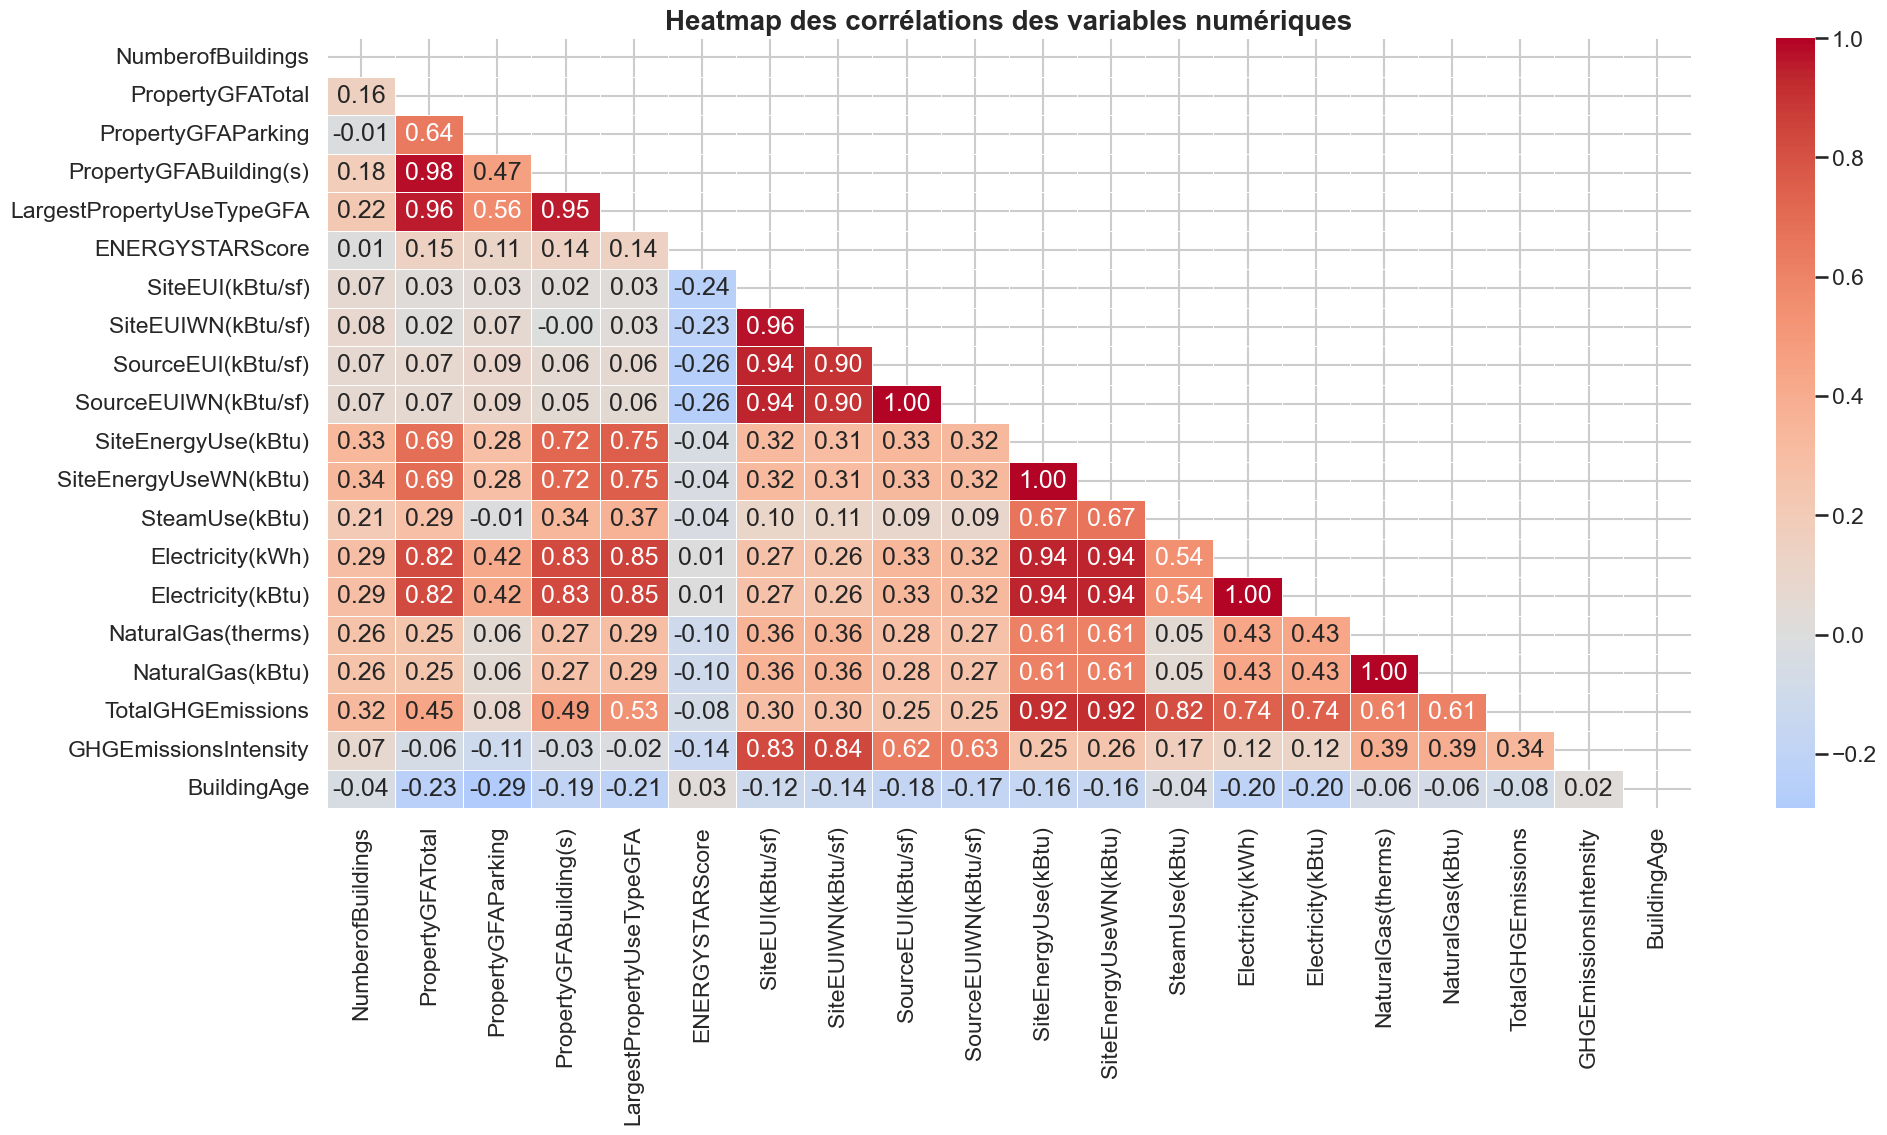

In [166]:
# Calculer la matrice de corrélation
corr_matrix = df_raw[numeric_vars].corr()

# Masque pour la partie supérieure
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Heatmap
plt.figure(figsize=(22, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    mask=mask,
    cmap='coolwarm',
    center=0,
    linewidths=0.7,
    fmt=".2f"
)
plt.title('Heatmap des corrélations des variables numériques', fontsize=20, fontweight='bold')
plt.show()

L’analyse des corrélations entre les variables numériques et la variable cible `TotalGHGEmissions` montre que certaines d’entre elles sont fortement liées aux émissions de gaz à effet de serre. En particulier, la consommation énergétique totale (`SiteEnergyUse(kBtu)`), la consommation d’électricité (`Electricity(kWh)`), le gaz naturel (`NaturalGas(therms)`) ainsi que la surface totale des bâtiments (`PropertyGFATotal` et `PropertyGFABuilding(s)`) présentent des corrélations élevées, supérieures à 0,5, ce qui indique qu’elles sont des facteurs déterminants des émissions. À l’inverse, des variables comme l’année de construction (`YearBuilt`) ou le nombre d’étages (`NumberofFloors`) montrent des corrélations faibles, suggérant un impact limité sur la variabilité des émissions totales. Ces résultats permettent d’orienter la sélection des variables explicatives pour les modèles de prédiction, tout en signalant la nécessité de gérer les redondances entre variables fortement corrélées, telles que différentes mesures de consommation énergétique.

# Section 7 : Analyse des variables qualitatives

### Description
Cette section réalise une **analyse univariée des variables catégorielles** du dataset de consommation énergétique et des émissions de CO₂ de Seattle.  
L'objectif est de **comprendre la distribution des catégories**, identifier les modalités dominantes et détecter d’éventuelles anomalies pour préparer le dataset pour le Machine Learning.

> **Philosophie :** "Explorer les catégories permet d’éviter les surprises dans le prétraitement et l’encodage des variables pour le modèle."

### Objectifs principaux
1. **Lister** toutes les variables catégorielles.
2. **Quantifier** le nombre de modalités uniques et les valeurs manquantes.
3. **Identifier** les modalités majoritaires et leur proportion.
4. **Visualiser** les distributions pour les variables clés.
5. **Préparer** un rapport synthétique pour guider l’encodage et la normalisation des variables catégorielles.

### Questions clés
* Combien de catégories uniques contient chaque variable ?
* Quelle est la catégorie la plus fréquente et sa proportion ?
* Existe-t-il des catégories très rares qui pourraient être regroupées ?

### Dépendances critiques
* `pandas`, `numpy` : Manipulation et analyse de données.
* `matplotlib`, `seaborn` : Visualisations graphiques.

### Livrables
1. **Tableau synthétique** des variables catégorielles avec nombre de modalités, valeurs manquantes, modalité majoritaire et proportion.  
2. **Graphiques** des distributions (Top 15 catégories) pour les variables clés.  
3. **Rapport PDF ou CSV** pour documentation et future préparation des données.

In [167]:
# Sélection des variables non numériques (qualitatives / catégorielles)
categorical_cols = df_raw.select_dtypes(exclude=[np.number]).columns.tolist()

# Affichage
categorical_cols

['BuildingType',
 'PrimaryPropertyType',
 'PropertyName',
 'Address',
 'City',
 'State',
 'TaxParcelIdentificationNumber',
 'Neighborhood',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'DefaultData',
 'ComplianceStatus',
 'AgeGroup']

In [168]:
print(f"Nombre de variables quantitatives : {len(categorical_cols)}")

Nombre de variables quantitatives : 13


In [169]:
df_raw['Neighborhood'] = df_raw['Neighborhood'].replace(
    'Delridge neighborhoods', 'Delridge'
)
df_raw['Neighborhood'] = df_raw['Neighborhood'].str.capitalize()

In [170]:
# Variables qualitatives d'intérêt
vars_quali = [
    'BuildingType',
    'PrimaryPropertyType',
    'Neighborhood',
    'ListOfAllPropertyUseTypes',
    'LargestPropertyUseType'
]

# Boucle sur chaque variable
for var in vars_quali:
    
    # Effectifs
    counts = df_raw[var].value_counts().head(12)
    
    # Fréquences relatives
    freqs = (counts / df_raw[var].count()) * 100
    
    # Tableau final
    table = pd.DataFrame({
        "Effectif": counts,
        "Fréquence (%)": freqs.round(2)
    })
    
    print("=" * 40)
    print(f"Modalités pour {var}")
    print("=" * 40)

    display(
        table.style
        .background_gradient(cmap="Reds", subset=["Effectif"])
        .background_gradient(cmap="Blues", subset=["Fréquence (%)"])
        .format({"Fréquence (%)": "{:.2f} %"})
    )

Modalités pour BuildingType


,Effectif,Fréquence (%)
BuildingType,,
NonResidential,1296,92.90 %
Nonresidential COS,73,5.23 %
Campus,17,1.22 %
SPS-District K-12,9,0.65 %


Modalités pour PrimaryPropertyType


,Effectif,Fréquence (%)
PrimaryPropertyType,,
Small- and Mid-Sized Office,272,19.50 %
Other,220,15.77 %
Warehouse,178,12.76 %
Large Office,160,11.47 %
Mixed Use Property,102,7.31 %
Retail Store,79,5.66 %
Hotel,68,4.87 %
Worship Facility,64,4.59 %
Distribution Center,47,3.37 %


Modalités pour Neighborhood


,Effectif,Fréquence (%)
Neighborhood,,
Downtown,322,23.08 %
Greater duwamish,308,22.08 %
Magnolia / queen anne,129,9.25 %
Lake union,126,9.03 %
East,101,7.24 %
Northeast,90,6.45 %
Northwest,71,5.09 %
Ballard,61,4.37 %
North,54,3.87 %


Modalités pour ListOfAllPropertyUseTypes


,Effectif,Fréquence (%)
ListOfAllPropertyUseTypes,,
Office,122,8.75 %
"Office, Parking",117,8.39 %
Non-Refrigerated Warehouse,96,6.88 %
"Non-Refrigerated Warehouse, Office",58,4.16 %
Retail Store,49,3.51 %
Other,49,3.51 %
Worship Facility,42,3.01 %
K-12 School,42,3.01 %
"Office, Retail Store",40,2.87 %


Modalités pour LargestPropertyUseType


,Effectif,Fréquence (%)
LargestPropertyUseType,,
Office,460,32.97 %
Non-Refrigerated Warehouse,190,13.62 %
Retail Store,87,6.24 %
Other,83,5.95 %
Hotel,69,4.95 %
Worship Facility,64,4.59 %
Distribution Center,48,3.44 %
K-12 School,46,3.30 %
Supermarket/Grocery Store,40,2.87 %


### Nuage de mots

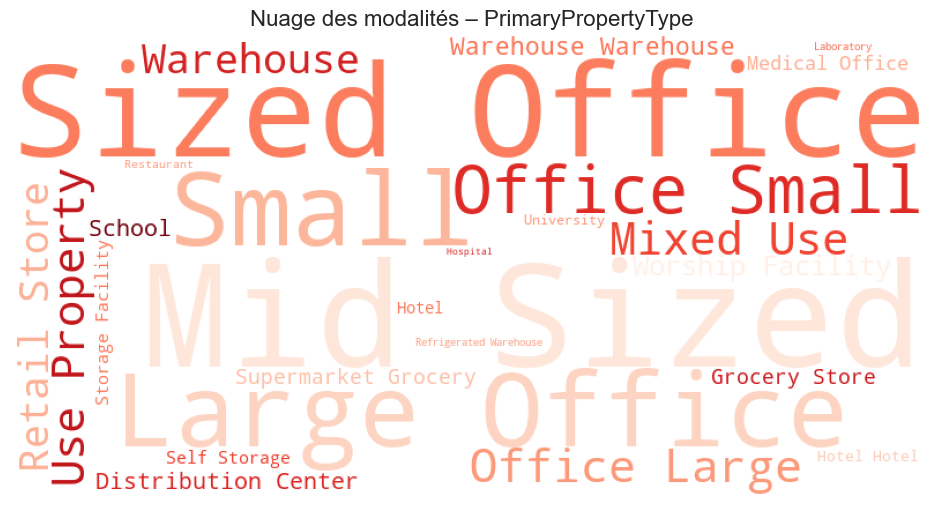

In [209]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

values = df_raw['PrimaryPropertyType'].dropna().astype(str)
text = " ".join(values)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds'
).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud.to_image())
plt.axis('off')
plt.title("Nuage des modalités – PrimaryPropertyType", fontsize=16)
plt.show()

Le nuage de modalités révèle une forte prédominance des bâtiments de type tertiaire, en particulier les Office de différentes tailles (Small, Mid Sized, Large), qui constituent la catégorie la plus représentée du dataset. Cette dominance reflète le poids important du secteur des bureaux dans le parc immobilier analysé.

On observe également la présence significative de bâtiments à usage commercial et logistique, tels que les Retail Store, Warehouse et Distribution Center, ainsi que des usages plus spécifiques (hôpitaux, écoles, hôtels). Cette diversité d’usages confirme confirme que la variable PrimaryPropertyType est hautement discriminante pour l’analyse énergétique et devra être encodée avec soin (regroupement de modalités proches) afin d’éviter une fragmentation excessive lors de la modélisation.

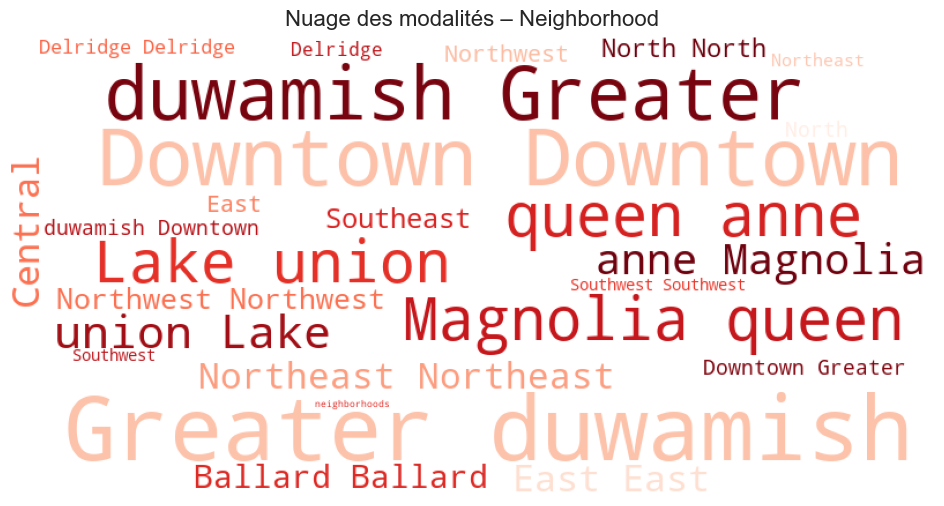

In [210]:
values = df_raw['Neighborhood'].dropna().astype(str)
text = " ".join(values)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds'
).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud.to_image())
plt.axis('off')
plt.title("Nuage des modalités – Neighborhood", fontsize=16)
plt.show()

Le nuage de modalités met en évidence une forte concentration des bâtiments dans certains quartiers, notamment Downtown, Greater Duwamish, Queen Anne, Magnolia et Lake Union. Ces zones apparaissent de manière dominante, traduisant leur poids structurel dans le parc immobilier étudié et suggérant une activité économique et immobilière plus dense.

La répétition de certaines modalités sous des formes légèrement différentes (Downtown, Greater Downtown, variations de casse ou de découpage) révèle également un problème de normalisation des catégories. Cela souligne la nécessité d’un nettoyage préalable (regroupement des modalités similaires) afin d’éviter une fragmentation artificielle de l’information lors de l’encodage et de la modélisation.

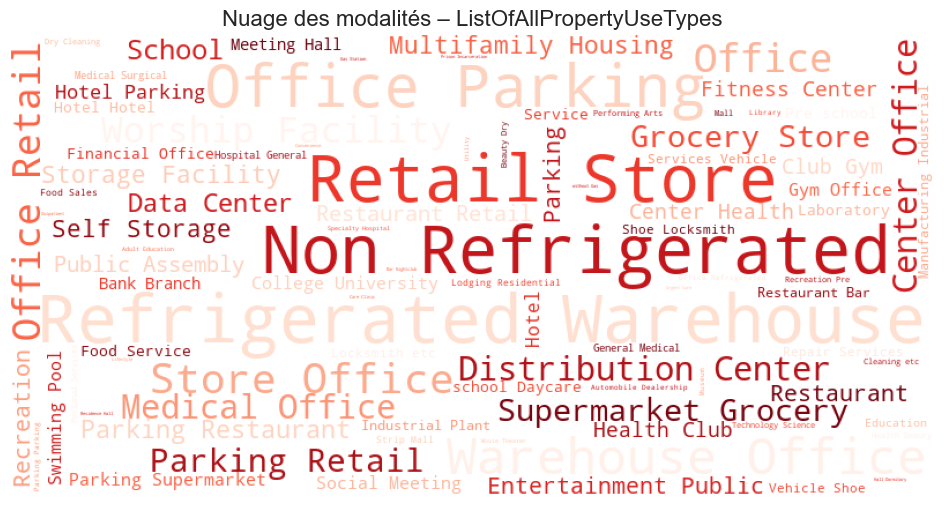

In [211]:
values = df_raw['ListOfAllPropertyUseTypes'].dropna().astype(str)
text = " ".join(values)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds'
).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud.to_image())
plt.axis('off')
plt.title("Nuage des modalités – ListOfAllPropertyUseTypes", fontsize=16)
plt.show()

Le nuage de modalités met en évidence une forte domination des usages commerciaux et tertiaires, notamment Retail Store, Office, Warehouse et Distribution Center. La présence marquée de modalités liées au commerce de détail, au stockage et aux bureaux suggère que le parc immobilier étudié est majoritairement orienté vers des activités économiques intensives, souvent associées à des besoins énergétiques élevés.

On observe également une diversité importante des usages secondaires (restaurants, centres médicaux, établissements éducatifs, lieux de loisirs), traduisant le caractère multi-usage de nombreux bâtiments. Cette hétérogénéité confirme la pertinence de cette variable pour expliquer les différences de consommation énergétique et d’émissions de GES, tout en soulignant la nécessité d’un regroupement ou d’un encodage adapté lors de la phase de modélisation.

### Suite
Dans le prochain notebook 03_notebook nous allons réaliser l'analyse bivariée.